#AWAL

In [1]:
pip install transformers

     |████████████████████████████████| 2.3MB 2.9MB/s 
     |████████████████████████████████| 3.3MB 21.0MB/s 
     |████████████████████████████████| 901kB 30.2MB/s 


In [2]:
import transformers
from transformers import BertModel, BertForSequenceClassification, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from collections import defaultdict
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
%matplotlib inline

if torch.cuda.is_available():
  device = torch.device('cuda')
  print('there are %d GPU(s) available.' % torch.cuda.device_count())
  print('we will use the GPU: ', torch.cuda.get_device_name(0))
else:
  print("No GPU available, using the CPU instead")
  device = torch.device("cpu")
  print(device)

No GPU available, using the CPU instead
cpu


In [3]:
EPOCHS = 2 #BERT Recommend using 2-4 EPOCH
LEARNING_RATE = 1e-5 #5e-5, 3e-5 or 2e-5 bert-base-multilingual, indobenchmark 1e-5 - 4e-5
DROPOUT = 0.2
BATCH_SIZE = 16
PRE_TRAINED_MODEL_BAHASA =  'indobenchmark/indobert-base-p1'
#PRE_TRAINED_MODEL_BAHASA =  'bert-base-multilingual-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_BAHASA)
MAX_LEN = 320

In [4]:

from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [5]:
#df = pd.read_csv('/content/drive/MyDrive/Skripsi/FIX/datasetBeritaFixWithDummies.csv') #KESELURUHAN DATA
train_df = pd.read_csv('/content/drive/MyDrive/Skripsi/FIX/datasetBeritaFixWithDummies.csv') #DUMMIESPAKE1 itu yg versi awal
validasi_data_baru_df = pd.read_csv('/content/drive/MyDrive/Skripsi/FIX/datasetBaruDenganDummies.csv') #DATA BARU
path = F"/content/drive/MyDrive/Skripsi/FIX/pengujian_model_fix/indobert-base-p1_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}.bin"
#path = F"/content/drive/MyDrive/Skripsi/FIX/pengujian_model_fix/{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}.bin"
#load_path = F"/content/drive/MyDrive/Skripsi/FIX/pengujian_model_fix/softmax_layer_1e-05_0.1_8_3_1.bin"

class_names = ['edukasi', 'tekno', 'sports', 'health', 'lifestyle']

train_df['list_kategori'] = list(train_df[class_names].values)
validasi_data_baru_df['list_kategori'] = list(validasi_data_baru_df[class_names].values)

In [ ]:
path

'/content/drive/MyDrive/Skripsi/FIX/pengujian_model_fix/indobert-base-p1_1e-05_0.2_16_2.bin'

In [ ]:
import statistics
sent_length = []

# For every sentence...
for sent in train_df.preprocessing_text:
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    sent_length.append(len(input_ids))

print('Average length = ', sum(sent_length)/len(sent_length))
#print('Median length = ', statistics.median(sent_length))

Average length =  319.77828412918564
Median length =  283


In [ ]:
#Classify
class DatasetBerita(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      truncation=True,
      return_tensors='pt',
    )
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [6]:
#Classify
class DatasetBerita(Dataset):
  def __init__(self, text, kategori, tokenizer, max_len):
    self.isi = text
    self.category = kategori
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.isi)
  def __getitem__(self, item):
    isi_berita = str(self.isi[item])
    kategori = self.category[item]
    encoding = self.tokenizer.encode_plus(
      isi_berita,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      truncation=True,
      return_tensors='pt',
    )
    return {
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      #'input_type_ids' : encoding['input_type_ids'],
      'targets': torch.tensor(kategori, dtype=torch.long)
    }

In [ ]:
data = next(iter(DatasetBerita(
    text=train_df.preprocessing_text.to_numpy(), #berdasarkan table di df
    kategori=train_df.list_kategori.to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN)))
data.keys()

dict_keys(['input_ids', 'attention_mask', 'targets'])

In [ ]:
df

,judul,url,isi,kategori,preprocessing_text,edukasi,health,lifestyle,sports,tekno,list_kategori
0,Pakar IPB: Jenis Makanan Ini Cegah Covid-19,https://www.kompas.com/edu/read/2021/01/01/164...,\n\n - Dosen IPB dari Departemen Ilmu dan Tekn...,edukasi,dosen ipb departemen ilmu teknologi pangan fak...,1,0,0,0,0,"[1, 0, 0, 0, 0]"
1,Semua Guru Honorer Madrasah Telah Terima Subsi...,https://www.kompas.com/edu/read/2021/01/01/133...,\n\n - Kementerian Agama (Kemenag) mengaku pro...,edukasi,menteri agama kemenag aku program bantu subsid...,1,0,0,0,0,"[1, 0, 0, 0, 0]"
2,6 Warna Jas Almamater Kampus di Indonesia dan ...,https://www.kompas.com/edu/read/2021/01/01/090...,"\n\n Bagi mahasiswa yang telah lulus kuliah, j...",edukasi,mahasiswa telah lulus kuliah jas almamater kam...,1,0,0,0,0,"[1, 0, 0, 0, 0]"
3,BPJS Kesehatan Buka 11 Lowongan Kerja untuk Lu...,https://www.kompas.com/edu/read/2021/01/01/074...,\n\n BPJS Kesehatan kembali membuka lowongan k...,edukasi,bpjs sehat buka lowong kerja isi bagai posisi ...,1,0,0,0,0,"[1, 0, 0, 0, 0]"
4,Mahasiswa UNY Gagas Sosis Tempe Jamur Tiram ya...,https://www.kompas.com/edu/read/2021/01/01/050...,\n\n Makanan yang satu ini sudah lazim di masy...,edukasi,makan satu sudah lazim masyarakat umum goreng ...,1,0,0,0,0,"[1, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...
6304,Aespa Remake Lagu Forever Milik Yoo Young Jin,https://lifestyle.sindonews.com/read/319284/15...,"Girl grup rookie SM Entertainment, Aespa ak...",lifestyle,girl grup rookie sm entertainment aespa rilis ...,0,0,1,0,0,"[0, 0, 0, 0, 1]"
6305,Jaehyun NCT Cemburu dengan Park Hye Soo,https://lifestyle.sindonews.com/read/319276/15...,Kabar mengejutkan datang dari Jaehyun NCT . ...,lifestyle,kabar kejut datang jaehyun nct nyata cemburu p...,0,0,1,0,0,"[0, 0, 0, 0, 1]"
6306,"Beli Rumah Rp 60 Miliar, Hyun Bin Siap Nikahi...",https://lifestyle.sindonews.com/read/319274/18...,Hyun Bin menanggapi rumor bahwa dia membeli r...,lifestyle,hyun bin tanggap rumor dia beli rumah siap nik...,0,0,1,0,0,"[0, 0, 0, 0, 1]"
6307,Drama Korea Sisyphus: The Myth Gunakan Lagu BTS,https://lifestyle.sindonews.com/read/319270/15...,Ada yang menarik dari teaser drama Korea Sisy...,lifestyle,tarik teaser drama korea sisyphus the myth tay...,0,0,1,0,0,"[0, 0, 0, 0, 1]"


In [7]:
RANDOM_SEED = 42
train_df, test_df = train_test_split(
  train_df,
  test_size=0.2, # train 80% val 20%
  random_state=RANDOM_SEED
)

In [8]:
len(train_df), len(test_df), len(validasi_data_baru_df)

(5047, 1262, 1285)

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = DatasetBerita(
    #text=df.preprocessing_text.to_numpy(), #berdasarkan table di df
    text=df.isi.to_numpy(),
    kategori=df.list_kategori.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [9]:
#BATCH_SIZE = 16
train_data_loader = DataLoader(DatasetBerita(
    train_df.preprocessing_text.to_numpy(),
    #train_df.isi.to_numpy(),
    kategori=train_df.list_kategori.to_numpy(),
    tokenizer=tokenizer,max_len=MAX_LEN), batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_data_loader = DataLoader(DatasetBerita(
    test_df.preprocessing_text.to_numpy(),
    #val_df.isi.to_numpy(),
    kategori=test_df.list_kategori.to_numpy(),
    tokenizer=tokenizer,max_len=MAX_LEN), batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
validasi_data_baru_data_loader = DataLoader(DatasetBerita(
    validasi_data_baru_df.preprocessing_text.to_numpy(),
    kategori=validasi_data_baru_df.list_kategori.to_numpy(),
    tokenizer=tokenizer,max_len=MAX_LEN), batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [7]:
validasi_data_baru_data_loader = DataLoader(DatasetBerita(
    validasi_data_baru_df.preprocessing_text.to_numpy(),
    kategori=validasi_data_baru_df.list_kategori.to_numpy(),
    tokenizer=tokenizer,max_len=MAX_LEN), batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
validasi_data_baru_data_loader = DataLoader(DatasetBerita(
    validasi_data_baru_df.preprocessing_text.to_numpy(),
    kategori=validasi_data_baru_df.list_kategori.to_numpy(),
    tokenizer=tokenizer,max_len=MAX_LEN), batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [10]:
class Klasifikasi(nn.Module):
  def __init__(self, n_classes, dropout_value=0.2):
    super(Klasifikasi, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_BAHASA)
    self.drop = nn.Dropout(p=dropout_value)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(pooled_output)

In [11]:
model = Klasifikasi(len(class_names), DROPOUT)
model = model.to(device)
print(DROPOUT)


0.2


In [12]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
#total_steps = int(len(train_data_loader) / BATCH_SIZE * EPOCHS)
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)
#print(f'steps1 {total_steps1} steps {total_steps}')

In [13]:
def train_epoch( model, data_loader, loss_fn, optimizer, device, scheduler):
  model = model.train()
  losses = []
  pred_labels = []
  true_labels = []
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    loss = loss_fn(outputs, torch.max(targets.float(), 1)[1])
    outputs = F.softmax(outputs,dim=1)

    b_probs = outputs.detach().cpu().numpy()
    b_targets = targets.detach().cpu().numpy()

    true_labels.append(b_targets)
    pred_labels.append(b_probs)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  
  pred_labels = [item for sublist in pred_labels for item in sublist]
  true_labels = [item for sublist in true_labels for item in sublist]
  
  threshold = 0.50
  pred_bools = [pl>threshold for pl in pred_labels]
  true_bools = [tl==1 for tl in true_labels]

  #return accuracy_score(true_bools, pred_bools), np.mean(losses), f1_score(true_bools, pred_bools, average='macro'), f1_score(true_bools, pred_bools, average='micro') 
  return accuracy_score(true_bools, pred_bools), np.mean(losses)

In [14]:
def eval_model(model, data_loader, loss_fn, device):
  model = model.eval()
  losses = []
  pred_labels = []
  true_labels = []

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      loss = loss_fn(outputs, torch.max(targets.float(), 1)[1])
      outputs = F.softmax(outputs,dim=1)

      b_probs = outputs.detach().cpu().numpy()
      b_targets = targets.detach().cpu().numpy()
      true_labels.append(b_targets)
      pred_labels.append(b_probs)
      losses.append(loss.item())

  pred_labels = [item for sublist in pred_labels for item in sublist]
  true_labels = [item for sublist in true_labels for item in sublist]
  threshold = 0.50
  pred_bools = [pl>threshold for pl in pred_labels]
  true_bools = [tl==1 for tl in true_labels]
  #return accuracy_score(true_bools, pred_bools), np.mean(losses), f1_score(true_bools, pred_bools, average='macro'), f1_score(true_bools, pred_bools, average='micro')
  return accuracy_score(true_bools, pred_bools), np.mean(losses)

In [16]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [15]:
path

'/content/drive/MyDrive/Skripsi/FIX/pengujian_model_fix/indobert-base-p1_1e-05_0.2_16_2.bin'

#PENGUJIAN FIXX 2e-5_0.2_16_3

##Learning rate


In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      #texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      #review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(F.softmax(outputs, dim=1))
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return predictions, prediction_probs, real_values
y_pred, y_pred_probs, y_test = get_predictions(
  model,
  validasi_data_baru_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


###1e-5

In [ ]:
%%time
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

softmax_layer_1e-05_0.2_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.30161063361299945 accuracy 0.8848821081830791
Val   loss 0.13208739259692875 accuracy 0.9548335974643423
Time : 0:05:22
Epoch 2/3
----------
Train loss 0.1405641857108773 accuracy 0.951852585694472
Val   loss 0.11306115441448704 accuracy 0.9611727416798732
Time : 0:05:27
Epoch 3/3
----------
Train loss 0.0827145951441224 accuracy 0.9706756489003369
Val   loss 0.11575053416817344 accuracy 0.9635499207606973
Time : 0:05:26
Rata-rata akurasi train 0.9358034475926292
Rata-rata akurasi test 0.9598520866349709
CPU times: user 15min 55s, sys: 12.9 s, total: 16min 8s
Wall time: 16min 34s


In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

softmax_layer_1e-05_0.2_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8785992217898833, 0.4332113844273543)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_1e-05_0.2_3.bin
              precision    recall  f1-score   support

     edukasi       0.96      0.93      0.94       330
       tekno       0.91      0.88      0.90       218
      sports       0.96      0.96      0.96       257
      health       0.67      0.44      0.53       107
   lifestyle       0.79      0.90      0.84       373

   micro avg       0.88      0.88      0.88      1285
   macro avg       0.86      0.82      0.83      1285
weighted avg       0.88      0.88      0.88      1285
 samples avg       0.88      0.88      0.88      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


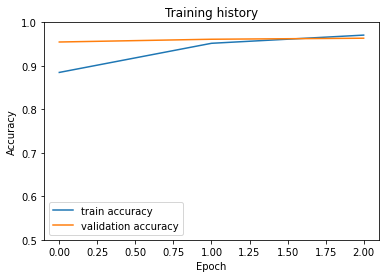

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

###2e-5

In [ ]:
%%time
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

softmax_layer_2e-05_0.2_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.3167231343391858 accuracy 0.8922131959579949
Val   loss 0.21132886014831595 accuracy 0.9263074484944532
Time : 0:05:12
Epoch 2/3
----------
Train loss 0.14667735695529469 accuracy 0.9528432732316228
Val   loss 0.13413629875536065 accuracy 0.9611727416798732
Time : 0:05:13
Epoch 3/3
----------
Train loss 0.08884403771496838 accuracy 0.973449574004359
Val   loss 0.15148871010640944 accuracy 0.9643423137876387
Time : 0:05:12
Rata-rata akurasi train 0.9395020143979922
Rata-rata akurasi test 0.9506075013206551
CPU times: user 15min 19s, sys: 12.4 s, total: 15min 31s
Wall time: 15min 54s


In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

softmax_layer_2e-05_0.2_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8583657587548638, 0.5949533196873273)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_2e-05_0.2_3.bin
              precision    recall  f1-score   support

     edukasi       0.95      0.89      0.92       330
       tekno       0.91      0.89      0.90       218
      sports       0.94      0.97      0.96       257
      health       0.64      0.15      0.24       107
   lifestyle       0.74      0.94      0.83       373

   micro avg       0.86      0.86      0.86      1285
   macro avg       0.84      0.77      0.77      1285
weighted avg       0.86      0.86      0.84      1285
 samples avg       0.86      0.86      0.86      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


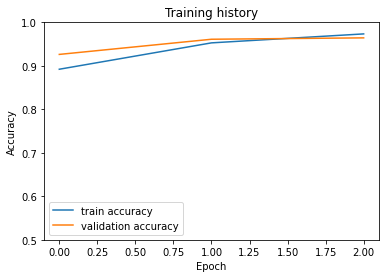

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


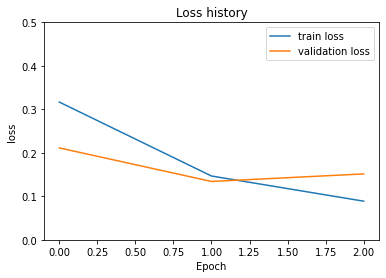

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

###3e-5

In [ ]:
%%time
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

softmax_layer_3e-05_0.2_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.4062222306634288 accuracy 0.8761640578561521
Val   loss 0.24278426230472477 accuracy 0.9310618066561014
Time : 0:09:33
Epoch 2/3
----------
Train loss 0.1837435356692022 accuracy 0.9451159104418466
Val   loss 0.1605251061824398 accuracy 0.9524564183835182
Time : 0:09:33
Epoch 3/3
----------
Train loss 0.1088780443327018 accuracy 0.9690905488408956
Val   loss 0.17270032535867083 accuracy 0.9580031695721077
Time : 0:09:34
Rata-rata akurasi train 0.9301235057129649
Rata-rata akurasi test 0.9471737982039091
CPU times: user 28min 13s, sys: 20.7 s, total: 28min 34s
Wall time: 28min 59s


In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

softmax_layer_3e-05_0.2_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8778210116731517, 0.47100036105221527)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_3e-05_0.2_3.bin
              precision    recall  f1-score   support

     edukasi       0.96      0.91      0.93       330
       tekno       0.93      0.88      0.90       218
      sports       0.96      0.96      0.96       257
      health       0.71      0.47      0.56       107
   lifestyle       0.78      0.91      0.84       373

   micro avg       0.88      0.88      0.88      1285
   macro avg       0.87      0.83      0.84      1285
weighted avg       0.88      0.88      0.88      1285
 samples avg       0.88      0.88      0.88      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


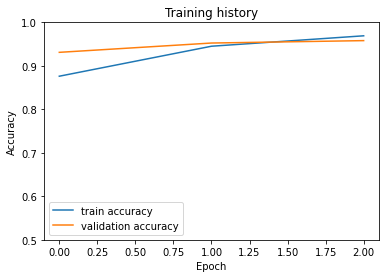

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


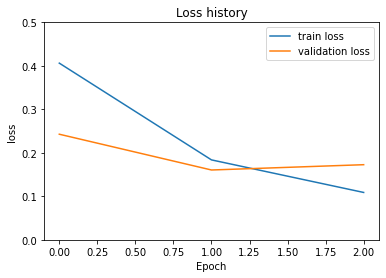

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

###4e-5

In [ ]:
%%time
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

softmax_layer_4e-05_0.2_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.6776442809525547 accuracy 0.7656033287101248
Val   loss 0.27476323749634285 accuracy 0.9247226624405706
Time : 0:09:57
Epoch 2/3
----------
Train loss 0.2784202114142525 accuracy 0.921537547057658
Val   loss 0.20091888289662857 accuracy 0.9437400950871633
Time : 0:09:58
Epoch 3/3
----------
Train loss 0.19818969461713223 accuracy 0.9449177729344165
Val   loss 0.1973337525961614 accuracy 0.9508716323296355
Time : 0:09:58
Rata-rata akurasi train 0.8773528829007331
Rata-rata akurasi test 0.9397781299524565
CPU times: user 29min 25s, sys: 21 s, total: 29min 46s
Wall time: 30min 13s


In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

softmax_layer_4e-05_0.2_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8653696498054475, 0.49596224841374303)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_4e-05_0.2_3.bin
              precision    recall  f1-score   support

     edukasi       0.95      0.90      0.93       330
       tekno       0.90      0.86      0.88       218
      sports       0.93      0.96      0.95       257
      health       0.63      0.57      0.60       107
   lifestyle       0.80      0.85      0.83       373

   micro avg       0.87      0.87      0.87      1285
   macro avg       0.84      0.83      0.84      1285
weighted avg       0.87      0.87      0.87      1285
 samples avg       0.87      0.87      0.87      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


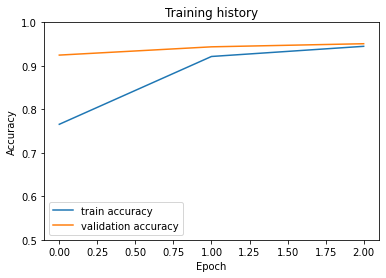

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


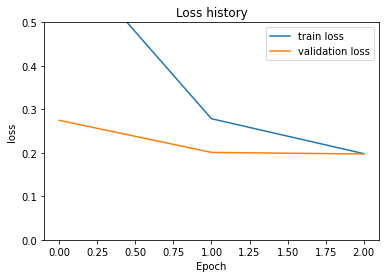

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

###5e-5

In [ ]:
%%time
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

softmax_layer_5e-05_0.2_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 1.0675473834706257 accuracy 0.33604121260154546
Val   loss 1.0406911976729767 accuracy 0.29556259904912835
Time : 0:05:34
Epoch 2/3
----------
Train loss 1.0166627592112445 accuracy 0.3235585496334456
Val   loss 0.9842776180822638 accuracy 0.3399366085578447
Time : 0:05:36
Epoch 3/3
----------
Train loss 0.9805192768196517 accuracy 0.3314840499306519
Val   loss 0.9620192654525177 accuracy 0.3359746434231379
Time : 0:05:36
Rata-rata akurasi train 0.330361270721881
Rata-rata akurasi test 0.32382461701003695
CPU times: user 16min 24s, sys: 12.3 s, total: 16min 36s
Wall time: 16min 56s


In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

softmax_layer_5e-05_0.2_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.17120622568093385, 1.2419421047340204)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_5e-05_0.2_3.bin
              precision    recall  f1-score   support

     edukasi       0.00      0.00      0.00       330
       tekno       0.00      0.00      0.00       218
      sports       0.95      0.86      0.90       257
      health       0.00      0.00      0.00       107
   lifestyle       0.00      0.00      0.00       373

   micro avg       0.95      0.17      0.29      1285
   macro avg       0.19      0.17      0.18      1285
weighted avg       0.19      0.17      0.18      1285
 samples avg       0.17      0.17      0.17      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


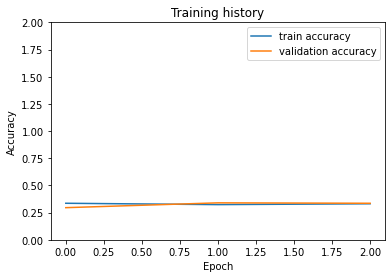

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 2]);


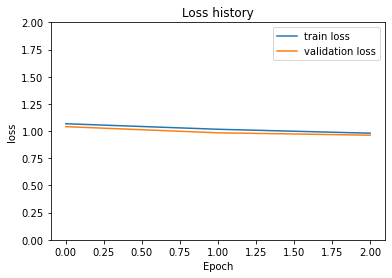

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 2]);

##Dropout


In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      #texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      #review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(F.softmax(outputs, dim=1))
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return predictions, prediction_probs, real_values
y_pred, y_pred_probs, y_test = get_predictions(
  model,
  validasi_data_baru_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


###0.1

In [ ]:
%%time
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

softmax_layer_1e-05_0.1_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.29396299411442506 accuracy 0.8880523083019616
Val   loss 0.13688677302384866 accuracy 0.9500792393026941
Time : 0:05:38
Epoch 2/3
----------
Train loss 0.13640721584375523 accuracy 0.94947493560531
Val   loss 0.11173132172331827 accuracy 0.9635499207606973
Time : 0:05:39
Epoch 3/3
----------
Train loss 0.08581904743693451 accuracy 0.973449574004359
Val   loss 0.11874233971385262 accuracy 0.9643423137876387
Time : 0:05:39
Rata-rata akurasi train 0.9369922726372102
Rata-rata akurasi test 0.95932382461701
CPU times: user 16min 37s, sys: 12.9 s, total: 16min 50s
Wall time: 17min 14s


In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

softmax_layer_1e-05_0.1_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8638132295719845, 0.5632782415458127)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_1e-05_0.1_3.bin
              precision    recall  f1-score   support

     edukasi       0.95      0.92      0.93       330
       tekno       0.89      0.90      0.90       218
      sports       0.96      0.97      0.97       257
      health       0.67      0.21      0.31       107
   lifestyle       0.75      0.91      0.83       373

   micro avg       0.87      0.86      0.86      1285
   macro avg       0.84      0.78      0.79      1285
weighted avg       0.86      0.86      0.85      1285
 samples avg       0.86      0.86      0.86      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


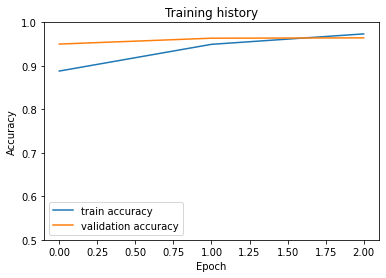

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


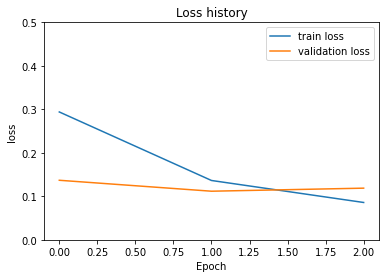

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

###0.2

In [ ]:
%%time
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

###0.3

In [ ]:
%%time
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

softmax_layer_1e-05_0.3_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.2944398688909869 accuracy 0.8900336833762631
Val   loss 0.14245405284499255 accuracy 0.9564183835182251
Time : 0:10:11
Epoch 2/3
----------
Train loss 0.12577193304071133 accuracy 0.9568060233802259
Val   loss 0.12088120780307564 accuracy 0.9635499207606973
Time : 0:10:11
Epoch 3/3
----------
Train loss 0.07859084449113123 accuracy 0.9742421240340796
Val   loss 0.121493133561556 accuracy 0.9659270998415214
Time : 0:10:10
Rata-rata akurasi train 0.9403606102635229
Rata-rata akurasi test 0.9619651347068147
CPU times: user 30min 2s, sys: 21.2 s, total: 30min 23s
Wall time: 30min 51s


In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

softmax_layer_1e-05_0.3_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8599221789883269, 0.5720246893434245)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_1e-05_0.3_3.bin
              precision    recall  f1-score   support

     edukasi       0.96      0.93      0.94       330
       tekno       0.90      0.90      0.90       218
      sports       0.96      0.96      0.96       257
      health       0.48      0.11      0.18       107
   lifestyle       0.75      0.92      0.82       373

   micro avg       0.86      0.86      0.86      1285
   macro avg       0.81      0.76      0.76      1285
weighted avg       0.85      0.86      0.84      1285
 samples avg       0.86      0.86      0.86      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


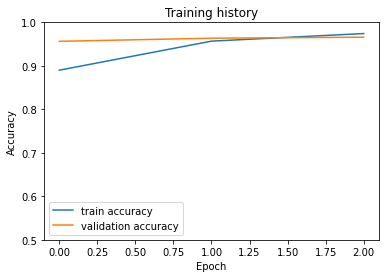

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


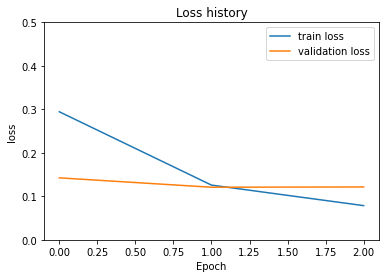

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

###0.4

###0.5

#PENGUJIAN LEARNING RATE DAN DROPOUT INDOBERT-BASE-P1

In [19]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      #texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      #review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(F.softmax(outputs, dim=1))
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return predictions, prediction_probs, real_values
y_pred, y_pred_probs, y_test = get_predictions(
  model,
  validasi_data_baru_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


##Learning rate 1e-5

###0.1

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

indobenchmark/indobert-base-p1_1e-05_0.1_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.2995533374008499 accuracy 0.8858727957202298
Val   loss 0.12842772773738148 accuracy 0.9580031695721077
Time : 0:05:17
Epoch 2/3
----------
Train loss 0.12687920837418495 accuracy 0.9574004359025163
Val   loss 0.11009277442847437 accuracy 0.9619651347068146
Time : 0:05:22
Epoch 3/3
----------
Train loss 0.0827690970386184 accuracy 0.972062611452348
Val   loss 0.11732752419583782 accuracy 0.9619651347068146
Time : 0:05:22
Rata-rata akurasi train 0.9384452810250314
Rata-rata akurasi test 0.9606444796619122
CPU times: user 15min 40s, sys: 11.5 s, total: 15min 52s
Wall time: 16min 12s


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

indobenchmark/indobert-base-p1_1e-05_0.1_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.863035019455253, 0.5620557629944538)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_1e-05_0.1_3.bin
              precision    recall  f1-score   support

     edukasi       0.96      0.92      0.93       330
       tekno       0.92      0.89      0.91       218
      sports       0.97      0.97      0.97       257
      health       0.58      0.13      0.21       107
   lifestyle       0.74      0.94      0.83       373

   micro avg       0.87      0.86      0.86      1285
   macro avg       0.83      0.77      0.77      1285
weighted avg       0.86      0.86      0.85      1285
 samples avg       0.86      0.86      0.86      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


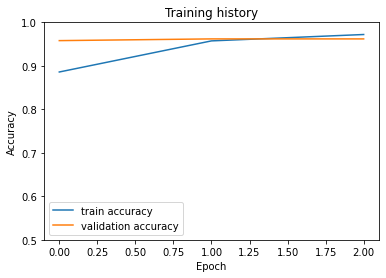

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


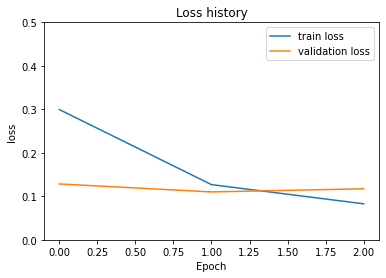

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

###0.2

####EPOCH 2

#####1

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

indobenchmark/indobert-base-p1_1e-05_0.2_16_2
Epoch 1/2
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.2853714196347408 accuracy 0.8870616207648108
Val   loss 0.14786717385242257 accuracy 0.945324881141046
Time : 0:03:02
Epoch 2/2
----------
Train loss 0.12692521172398818 accuracy 0.9560134733505052
Val   loss 0.1261143596736785 accuracy 0.9548335974643423
Time : 0:03:01
Rata-rata akurasi train 0.921537547057658
Rata-rata akurasi test 0.9500792393026941
CPU times: user 5min 55s, sys: 3.48 s, total: 5min 58s
Wall time: 6min 14s


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

indobenchmark/indobert-base-p1_1e-05_0.2_16_2


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8809338521400778, 0.3644636278895857)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_1e-05_0.2_2.bin
              precision    recall  f1-score   support

     edukasi       0.95      0.90      0.92       330
       tekno       0.90      0.90      0.90       218
      sports       0.97      0.96      0.97       257
      health       0.67      0.64      0.65       107
   lifestyle       0.82      0.87      0.84       373

   micro avg       0.88      0.88      0.88      1285
   macro avg       0.86      0.85      0.86      1285
weighted avg       0.88      0.88      0.88      1285
 samples avg       0.88      0.88      0.88      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


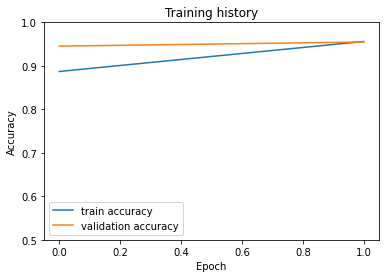

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


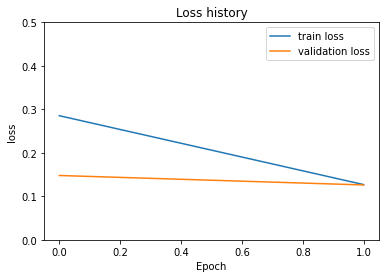

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

#####Pengujian klasifikasi

In [17]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

indobenchmark/indobert-base-p1_1e-05_0.2_16_2
Epoch 1/2
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.30073211668943395 accuracy 0.8803249455121854
Val   loss 0.13884271571672038 accuracy 0.9516640253565769
Time : 0:05:20
Epoch 2/2
----------
Train loss 0.1268198497798235 accuracy 0.9574004359025163
Val   loss 0.11559200845364057 accuracy 0.9635499207606973
Time : 0:05:21
Rata-rata akurasi train 0.9188626907073509
Rata-rata akurasi test 0.9576069730586372
CPU times: user 10min 28s, sys: 8.64 s, total: 10min 37s
Wall time: 10min 53s


In [18]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

indobenchmark/indobert-base-p1_1e-05_0.2_16_2


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8684824902723736, 0.41737390688425047)

In [20]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_1e-05_0.2_2.bin
              precision    recall  f1-score   support

     edukasi       0.95      0.90      0.92       330
       tekno       0.89      0.92      0.90       218
      sports       0.97      0.96      0.96       257
      health       0.73      0.30      0.42       107
   lifestyle       0.77      0.92      0.83       373

   micro avg       0.87      0.87      0.87      1285
   macro avg       0.86      0.80      0.81      1285
weighted avg       0.87      0.87      0.86      1285
 samples avg       0.87      0.87      0.87      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


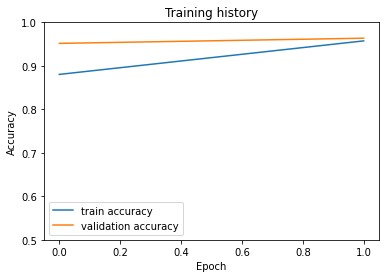

In [21]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


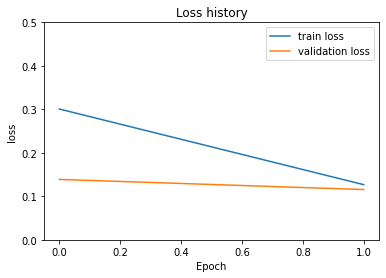

In [22]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

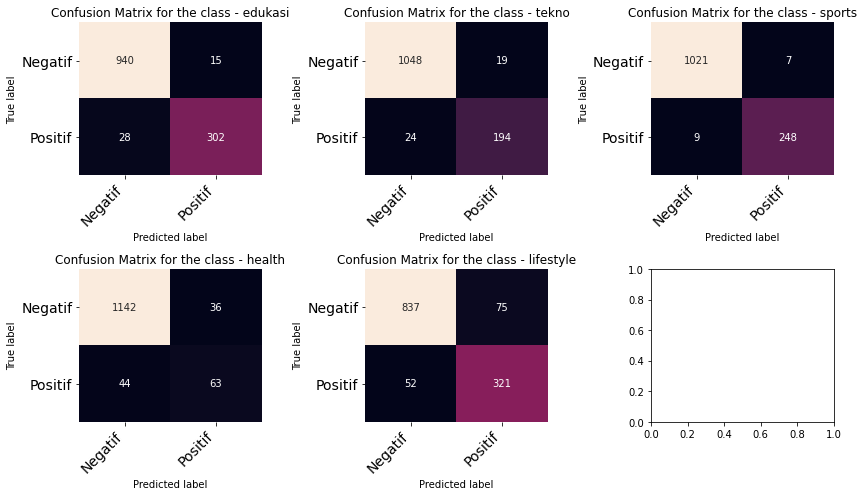

In [23]:
from sklearn.metrics import multilabel_confusion_matrix
cf_matrix = multilabel_confusion_matrix(y_test, y_pred_probs>0.5)
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)
fig, ax = plt.subplots(2, 3, figsize=(12, 7))
for axes, cfs_matrix, label in zip(ax.flatten(), cf_matrix, class_names):
    print_confusion_matrix(cfs_matrix, axes, label, ["Negatif", "Positif"])

fig.tight_layout()
plt.show()

#### EPOCH 3

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

indobenchmark/indobert-base-p1_1e-05_0.2_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.30169416703519564 accuracy 0.8811174955419061
Val   loss 0.14810529654208995 accuracy 0.9484944532488114
Time : 0:05:42
Epoch 2/3
----------
Train loss 0.12445233839702545 accuracy 0.9587873984545274
Val   loss 0.11252406982209863 accuracy 0.9683042789223455
Time : 0:05:54
Epoch 3/3
----------
Train loss 0.07618960541639111 accuracy 0.9738458490192193
Val   loss 0.11272143609409185 accuracy 0.9698890649762282
Time : 0:05:54
Rata-rata akurasi train 0.937916914338551
Rata-rata akurasi test 0.962229265715795
CPU times: user 17min 9s, sys: 13.3 s, total: 17min 22s
Wall time: 17min 47s


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

indobenchmark/indobert-base-p1_1e-05_0.2_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.867704280155642, 0.5134668747857098)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_1e-05_0.2_3.bin
              precision    recall  f1-score   support

     edukasi       0.95      0.92      0.94       330
       tekno       0.92      0.89      0.90       218
      sports       0.98      0.97      0.97       257
      health       0.61      0.16      0.25       107
   lifestyle       0.75      0.94      0.83       373

   micro avg       0.87      0.87      0.87      1285
   macro avg       0.84      0.78      0.78      1285
weighted avg       0.86      0.87      0.85      1285
 samples avg       0.87      0.87      0.87      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


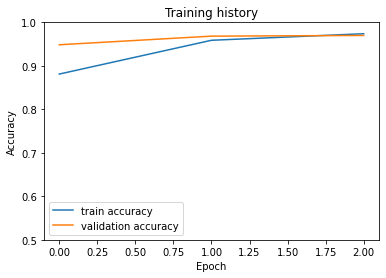

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


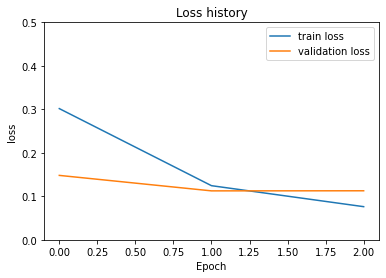

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

#### EPOCH 4

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

indobenchmark/indobert-base-p1_1e-05_0.2_16_4
Epoch 1/4
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.3094202995232507 accuracy 0.8795323954824649
Val   loss 0.15760044720542582 accuracy 0.9469096671949286
Time : 0:05:45
Epoch 2/4
----------
Train loss 0.1280589720663096 accuracy 0.955617198335645
Val   loss 0.10335124349310004 accuracy 0.9667194928684627
Time : 0:05:51
Epoch 3/4
----------
Train loss 0.07619461516703809 accuracy 0.9758272240935209
Val   loss 0.10978037869274805 accuracy 0.9690966719492868
Time : 0:05:50
Epoch 4/4
----------
Train loss 0.04584632230582912 accuracy 0.9845452744204478
Val   loss 0.12293161374157224 accuracy 0.96513470681458
Time : 0:05:50
Rata-rata akurasi train 0.9488805230830196
Rata-rata akurasi test 0.9619651347068146
CPU times: user 22min 48s, sys: 15.9 s, total: 23min 4s
Wall time: 23min 33s


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

indobenchmark/indobert-base-p1_1e-05_0.2_16_4


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8591439688715953, 0.7982225479456786)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_1e-05_0.2_4.bin
              precision    recall  f1-score   support

     edukasi       0.96      0.92      0.94       330
       tekno       0.92      0.89      0.91       218
      sports       0.97      0.97      0.97       257
      health       0.31      0.04      0.07       107
   lifestyle       0.73      0.94      0.82       373

   micro avg       0.86      0.86      0.86      1285
   macro avg       0.78      0.75      0.74      1285
weighted avg       0.83      0.86      0.83      1285
 samples avg       0.86      0.86      0.86      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


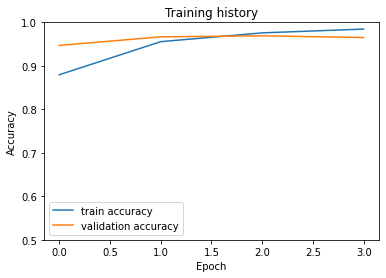

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


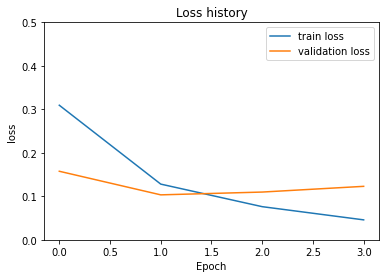

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

###0.3

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

indobenchmark/indobert-base-p1_1e-05_0.3_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.29001502770506127 accuracy 0.8852783831979394
Val   loss 0.13554473536065484 accuracy 0.9564183835182251
Time : 0:05:56
Epoch 2/3
----------
Train loss 0.11792511759101873 accuracy 0.9589855359619576
Val   loss 0.10019106421431032 accuracy 0.9706814580031695
Time : 0:06:00
Epoch 3/3
----------
Train loss 0.06939864128384492 accuracy 0.9764216366158114
Val   loss 0.10740356485335793 accuracy 0.9690966719492868
Time : 0:06:00
Rata-rata akurasi train 0.9402285185919027
Rata-rata akurasi test 0.9653988378235604
CPU times: user 17min 34s, sys: 12.1 s, total: 17min 46s
Wall time: 18min 7s
Parser   : 153 ms


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

indobenchmark/indobert-base-p1_1e-05_0.3_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8614785992217899, 0.6748228568337962)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_1e-05_0.3_3.bin
              precision    recall  f1-score   support

     edukasi       0.96      0.92      0.94       330
       tekno       0.92      0.90      0.91       218
      sports       0.97      0.97      0.97       257
      health       0.45      0.05      0.08       107
   lifestyle       0.73      0.94      0.82       373

   micro avg       0.86      0.86      0.86      1285
   macro avg       0.81      0.76      0.75      1285
weighted avg       0.84      0.86      0.84      1285
 samples avg       0.86      0.86      0.86      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


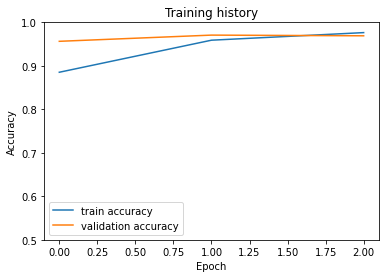

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


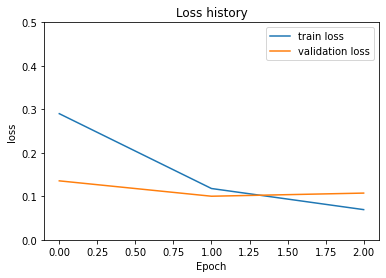

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

###0.4

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

indobenchmark/indobert-base-p1_1e-05_0.4_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.3030691233793674 accuracy 0.8862690707350902
Val   loss 0.1436999276622281 accuracy 0.9484944532488114
Time : 0:05:27
Epoch 2/3
----------
Train loss 0.13228188268987673 accuracy 0.9546265107984941
Val   loss 0.12125779932388399 accuracy 0.9587955625990491
Time : 0:05:46
Epoch 3/3
----------
Train loss 0.08506974806092514 accuracy 0.9712700614226273
Val   loss 0.11913216522971427 accuracy 0.9635499207606973
Time : 0:05:46
Rata-rata akurasi train 0.9373885476520706
Rata-rata akurasi test 0.956946645536186
CPU times: user 16min 40s, sys: 12.8 s, total: 16min 53s
Wall time: 17min 17s


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

indobenchmark/indobert-base-p1_1e-05_0.4_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8583657587548638, 0.5300490111213201)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_1e-05_0.4_3.bin
              precision    recall  f1-score   support

     edukasi       0.96      0.92      0.94       330
       tekno       0.92      0.87      0.89       218
      sports       0.96      0.97      0.97       257
      health       0.53      0.09      0.16       107
   lifestyle       0.73      0.94      0.82       373

   micro avg       0.86      0.86      0.86      1285
   macro avg       0.82      0.76      0.76      1285
weighted avg       0.85      0.86      0.84      1285
 samples avg       0.86      0.86      0.86      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


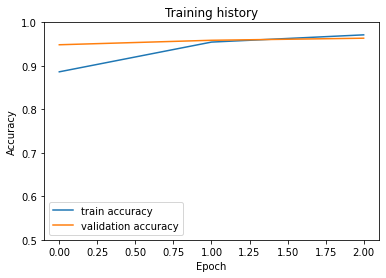

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


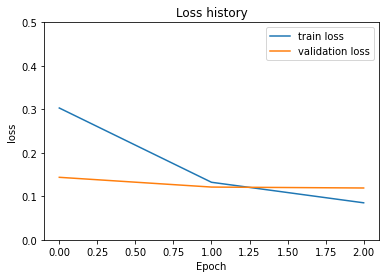

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

###0.5

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

indobenchmark/indobert-base-p1_1e-05_0.5_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.29450724623460744 accuracy 0.8836932831384982
Val   loss 0.14178870170365407 accuracy 0.945324881141046
Time : 0:05:53
Epoch 2/3
----------
Train loss 0.12002848926600057 accuracy 0.958192985932237
Val   loss 0.10887340508413183 accuracy 0.9635499207606973
Time : 0:05:54
Epoch 3/3
----------
Train loss 0.07187176244723893 accuracy 0.9758272240935209
Val   loss 0.12415976882646969 accuracy 0.9603803486529319
Time : 0:05:54
Rata-rata akurasi train 0.939237831054752
Rata-rata akurasi test 0.9564183835182251
CPU times: user 17min 20s, sys: 11.9 s, total: 17min 31s
Wall time: 17min 53s


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

indobenchmark/indobert-base-p1_1e-05_0.5_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8599221789883269, 0.5579739861933365)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_1e-05_0.5_3.bin
              precision    recall  f1-score   support

     edukasi       0.95      0.90      0.92       330
       tekno       0.89      0.89      0.89       218
      sports       0.96      0.97      0.97       257
      health       0.59      0.21      0.31       107
   lifestyle       0.75      0.92      0.83       373

   micro avg       0.86      0.86      0.86      1285
   macro avg       0.83      0.78      0.78      1285
weighted avg       0.86      0.86      0.85      1285
 samples avg       0.86      0.86      0.86      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


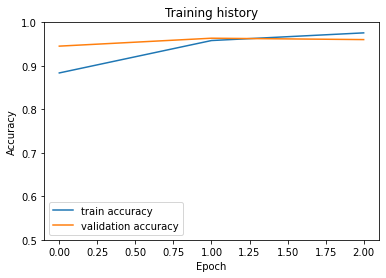

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


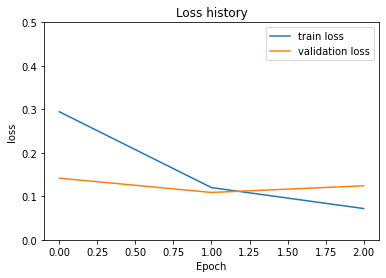

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

##2e-5

###0.1

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

indobenchmark/indobert-base-p1_2e-05_0.1_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.34902329736424587 accuracy 0.8795323954824649
Val   loss 0.16218981187484122 accuracy 0.9477020602218701
Time : 0:05:39
Epoch 2/3
----------
Train loss 0.14692498849192046 accuracy 0.9550227858133544
Val   loss 0.1479285781395539 accuracy 0.9580031695721077
Time : 0:05:46
Epoch 3/3
----------
Train loss 0.09266013084893127 accuracy 0.9730532989894987
Val   loss 0.13867716616479372 accuracy 0.9619651347068146
Time : 0:05:46
Rata-rata akurasi train 0.9358694934284393
Rata-rata akurasi test 0.9558901215002642
CPU times: user 16min 52s, sys: 12.8 s, total: 17min 5s
Wall time: 17min 28s


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

indobenchmark/indobert-base-p1_2e-05_0.1_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.863035019455253, 0.6044654705821116)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_2e-05_0.1_3.bin
              precision    recall  f1-score   support

     edukasi       0.95      0.92      0.93       330
       tekno       0.91      0.89      0.90       218
      sports       0.94      0.96      0.95       257
      health       0.72      0.12      0.21       107
   lifestyle       0.75      0.95      0.84       373

   micro avg       0.86      0.86      0.86      1285
   macro avg       0.85      0.77      0.77      1285
weighted avg       0.86      0.86      0.84      1285
 samples avg       0.86      0.86      0.86      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


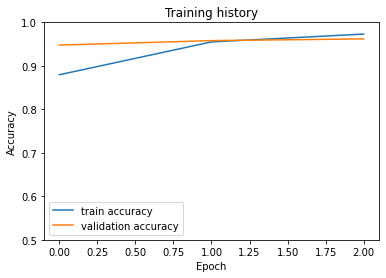

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


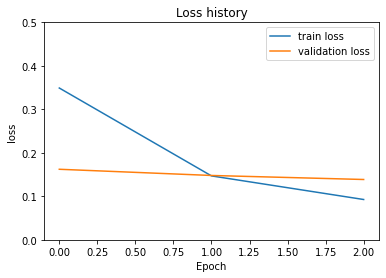

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

###0.2

####EPOCH 2

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

indobenchmark/indobert-base-p1_2e-05_0.2_16_2
Epoch 1/2
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.3379101311976585 accuracy 0.8829007331087775
Val   loss 0.17176996318835624 accuracy 0.9445324881141046
Time : 0:03:01
Epoch 2/2
----------
Train loss 0.14538984883965664 accuracy 0.9554190608282148
Val   loss 0.12176281145090072 accuracy 0.9635499207606973
Time : 0:03:01
Rata-rata akurasi train 0.9191598969684962
Rata-rata akurasi test 0.9540412044374009
CPU times: user 5min 55s, sys: 3.19 s, total: 5min 58s
Wall time: 6min 13s


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

indobenchmark/indobert-base-p1_2e-05_0.2_16_2


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8536964980544747, 0.5647207062481615)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_2e-05_0.2_2.bin
              precision    recall  f1-score   support

     edukasi       0.96      0.91      0.93       330
       tekno       0.89      0.91      0.90       218
      sports       0.96      0.97      0.96       257
      health       0.36      0.04      0.07       107
   lifestyle       0.73      0.93      0.82       373

   micro avg       0.86      0.85      0.86      1285
   macro avg       0.78      0.75      0.74      1285
weighted avg       0.83      0.85      0.83      1285
 samples avg       0.85      0.85      0.85      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


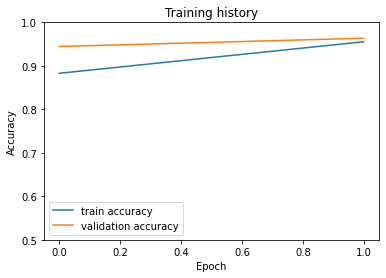

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


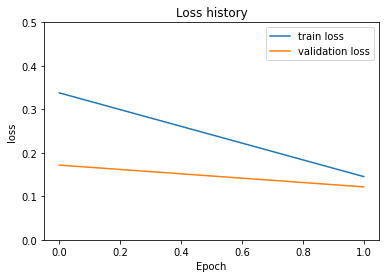

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

####EPOCH 3

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

indobenchmark/indobert-base-p1_2e-05_0.2_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.3642695611711191 accuracy 0.8708143451555379
Val   loss 0.15276926827227957 accuracy 0.9556259904912837
Time : 0:05:39
Epoch 2/3
----------
Train loss 0.16013366219519837 accuracy 0.9496730731127403
Val   loss 0.13098153939081617 accuracy 0.9611727416798732
Time : 0:05:40
Epoch 3/3
----------
Train loss 0.10279934780187375 accuracy 0.9679017237963147
Val   loss 0.130400787352266 accuracy 0.9611727416798732
Time : 0:05:40
Rata-rata akurasi train 0.9294630473548643
Rata-rata akurasi test 0.95932382461701
CPU times: user 16min 38s, sys: 11.9 s, total: 16min 50s
Wall time: 17min 10s


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

indobenchmark/indobert-base-p1_2e-05_0.2_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8692607003891051, 0.6023162455286508)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_2e-05_0.2_3.bin
              precision    recall  f1-score   support

     edukasi       0.95      0.94      0.95       330
       tekno       0.93      0.92      0.93       218
      sports       0.96      0.97      0.96       257
      health       0.53      0.08      0.15       107
   lifestyle       0.75      0.93      0.83       373

   micro avg       0.87      0.87      0.87      1285
   macro avg       0.82      0.77      0.76      1285
weighted avg       0.86      0.87      0.85      1285
 samples avg       0.87      0.87      0.87      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


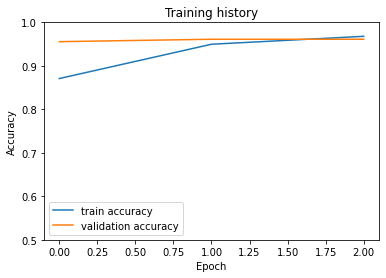

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


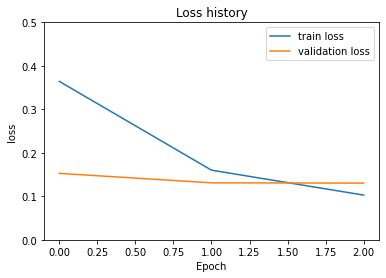

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

####EPOCH 4

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

indobenchmark/indobert-base-p1_2e-05_0.2_16_4
Epoch 1/4
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.34414534590242407 accuracy 0.883495145631068
Val   loss 0.20297459810029103 accuracy 0.9405705229793978
Time : 0:09:32
Epoch 2/4
----------
Train loss 0.1643821015387414 accuracy 0.9468991480087181
Val   loss 0.1715729332564375 accuracy 0.9508716323296355
Time : 0:09:31
Epoch 3/4
----------
Train loss 0.09417705118447642 accuracy 0.972062611452348
Val   loss 0.16639281828929023 accuracy 0.9540412044374009
Time : 0:09:31
Epoch 4/4
----------
Train loss 0.05198256417267508 accuracy 0.9849415494353081
Val   loss 0.18239965478527137 accuracy 0.9540412044374009
Time : 0:09:31
Rata-rata akurasi train 0.9468496136318605
Rata-rata akurasi test 0.9498811410459588
CPU times: user 37min 28s, sys: 25 s, total: 37min 53s
Wall time: 38min 23s


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

indobenchmark/indobert-base-p1_2e-05_0.2_16_4


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8552529182879377, 0.7278693503323643)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_2e-05_0.2_4.bin
              precision    recall  f1-score   support

     edukasi       0.95      0.93      0.94       330
       tekno       0.93      0.88      0.90       218
      sports       0.96      0.97      0.96       257
      health       0.36      0.05      0.08       107
   lifestyle       0.72      0.93      0.81       373

   micro avg       0.86      0.86      0.86      1285
   macro avg       0.78      0.75      0.74      1285
weighted avg       0.83      0.86      0.83      1285
 samples avg       0.86      0.86      0.86      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


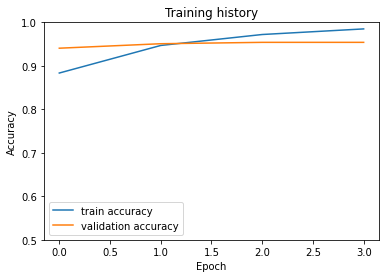

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


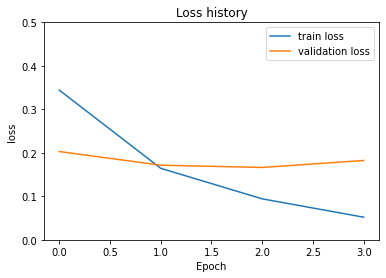

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

###0.3

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

indobenchmark/indobert-base-p1_2e-05_0.3_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.3396603315007649 accuracy 0.8793342579750347
Val   loss 0.14492253863099444 accuracy 0.9508716323296355
Time : 0:05:27
Epoch 2/3
----------
Train loss 0.14335237134283385 accuracy 0.955617198335645
Val   loss 0.12281701031223505 accuracy 0.9603803486529319
Time : 0:05:38
Epoch 3/3
----------
Train loss 0.0760444556878691 accuracy 0.9764216366158114
Val   loss 0.1262379184518528 accuracy 0.96513470681458
Time : 0:05:38
Rata-rata akurasi train 0.9371243643088304
Rata-rata akurasi test 0.9587955625990491
CPU times: user 16min 22s, sys: 13.2 s, total: 16min 35s
Wall time: 17min


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

indobenchmark/indobert-base-p1_2e-05_0.3_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8638132295719845, 0.6117052098813058)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_2e-05_0.3_3.bin
              precision    recall  f1-score   support

     edukasi       0.96      0.94      0.95       330
       tekno       0.92      0.89      0.90       218
      sports       0.97      0.96      0.97       257
      health       0.55      0.06      0.10       107
   lifestyle       0.74      0.95      0.83       373

   micro avg       0.87      0.86      0.87      1285
   macro avg       0.83      0.76      0.75      1285
weighted avg       0.86      0.86      0.84      1285
 samples avg       0.86      0.86      0.86      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


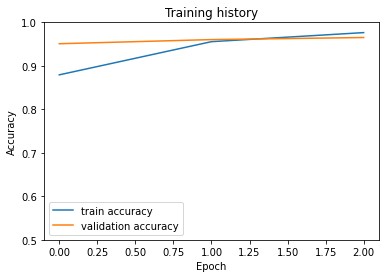

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


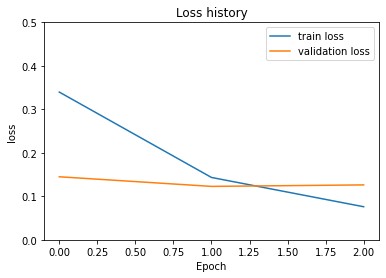

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

###0.4

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

indobenchmark/indobert-base-p1_2e-05_0.4_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.32319001507314654 accuracy 0.8803249455121854
Val   loss 0.14435132568749257 accuracy 0.9492868462757528
Time : 0:05:25
Epoch 2/3
----------
Train loss 0.13553412777262658 accuracy 0.9583911234396671
Val   loss 0.13288260212232936 accuracy 0.9580031695721077
Time : 0:05:42
Epoch 3/3
----------
Train loss 0.07580362663190235 accuracy 0.9768179116306717
Val   loss 0.14984293455034023 accuracy 0.9603803486529319
Time : 0:05:43
Rata-rata akurasi train 0.9385113268608413
Rata-rata akurasi test 0.9558901215002642
CPU times: user 16min 30s, sys: 12.9 s, total: 16min 43s
Wall time: 17min 7s


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

indobenchmark/indobert-base-p1_2e-05_0.4_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8536964980544747, 0.7387909061296263)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_2e-05_0.4_3.bin
              precision    recall  f1-score   support

     edukasi       0.95      0.92      0.93       330
       tekno       0.89      0.90      0.89       218
      sports       0.96      0.96      0.96       257
      health       0.31      0.04      0.07       107
   lifestyle       0.73      0.93      0.82       373

   micro avg       0.86      0.85      0.85      1285
   macro avg       0.77      0.75      0.74      1285
weighted avg       0.83      0.85      0.83      1285
 samples avg       0.85      0.85      0.85      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


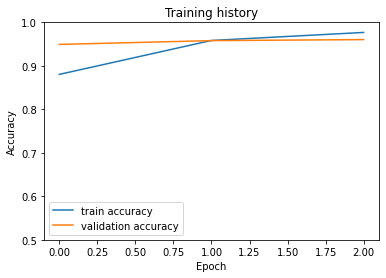

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


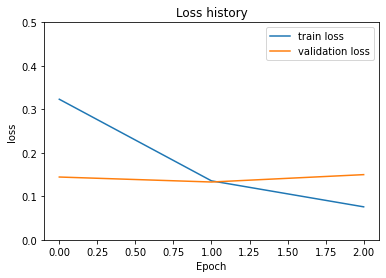

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

###0.5

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

indobenchmark/indobert-base-p1_2e-05_0.5_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.37410426438974714 accuracy 0.8662571824846443
Val   loss 0.19204317150000907 accuracy 0.9358161648177497
Time : 0:05:13
Epoch 2/3
----------
Train loss 0.16069878758332115 accuracy 0.9465028729938577
Val   loss 0.1485836993655355 accuracy 0.9556259904912837
Time : 0:05:21
Epoch 3/3
----------
Train loss 0.10311346074096163 accuracy 0.9684961363186051
Val   loss 0.1413909324055797 accuracy 0.9619651347068146
Time : 0:05:18
Rata-rata akurasi train 0.9270853972657024
Rata-rata akurasi test 0.9511357633386158
CPU times: user 15min 31s, sys: 12.7 s, total: 15min 44s
Wall time: 16min 10s
Parser   : 156 ms


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

indobenchmark/indobert-base-p1_2e-05_0.5_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8669260700389105, 0.5027649954930062)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_2e-05_0.5_3.bin
              precision    recall  f1-score   support

     edukasi       0.95      0.94      0.94       330
       tekno       0.92      0.90      0.91       218
      sports       0.96      0.96      0.96       257
      health       0.67      0.13      0.22       107
   lifestyle       0.74      0.93      0.82       373

   micro avg       0.87      0.87      0.87      1285
   macro avg       0.85      0.77      0.77      1285
weighted avg       0.87      0.87      0.85      1285
 samples avg       0.87      0.87      0.87      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


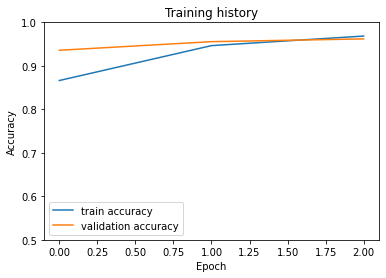

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


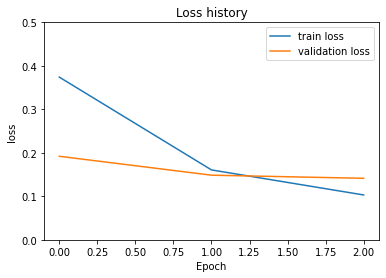

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

##3e-5

###0.1

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

indobenchmark/indobert-base-p1_3e-05_0.1_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.39191682635706293 accuracy 0.8672478700217952
Val   loss 0.2091804987373703 accuracy 0.93026941362916
Time : 0:05:42
Epoch 2/3
----------
Train loss 0.18440424393467558 accuracy 0.9472954230235784
Val   loss 0.16933560312159737 accuracy 0.9492868462757528
Time : 0:05:49
Epoch 3/3
----------
Train loss 0.11590743332193527 accuracy 0.9665147612443036
Val   loss 0.16495064656615635 accuracy 0.9548335974643423
Time : 0:05:48
Rata-rata akurasi train 0.9270193514298923
Rata-rata akurasi test 0.944796619123085
CPU times: user 16min 59s, sys: 12.7 s, total: 17min 11s
Wall time: 17min 35s


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

indobenchmark/indobert-base-p1_3e-05_0.1_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8591439688715953, 0.5896867793441439)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_3e-05_0.1_3.bin
              precision    recall  f1-score   support

     edukasi       0.96      0.93      0.94       330
       tekno       0.92      0.87      0.89       218
      sports       0.93      0.97      0.95       257
      health       0.64      0.13      0.22       107
   lifestyle       0.74      0.92      0.82       373

   micro avg       0.86      0.86      0.86      1285
   macro avg       0.84      0.76      0.76      1285
weighted avg       0.85      0.86      0.84      1285
 samples avg       0.86      0.86      0.86      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


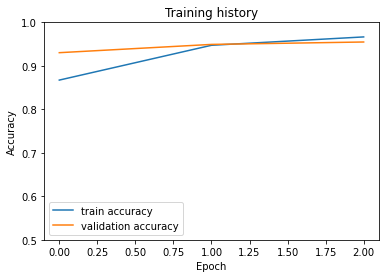

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


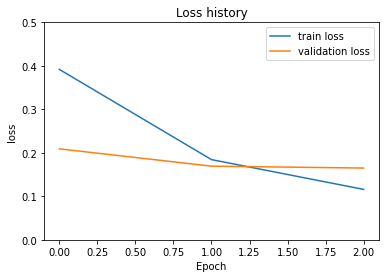

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

###0.2

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

indobenchmark/indobert-base-p1_3e-05_0.2_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.40600916014724897 accuracy 0.8575391321577175
Val   loss 0.18277228666068632 accuracy 0.9429477020602218
Time : 0:03:02
Epoch 2/3
----------
Train loss 0.18442160245384784 accuracy 0.9437289478898355
Val   loss 0.15727079753422096 accuracy 0.9572107765451664
Time : 0:03:01
Epoch 3/3
----------
Train loss 0.11274859813171663 accuracy 0.967109173766594
Val   loss 0.16331988194650865 accuracy 0.9572107765451664
Time : 0:03:01
Rata-rata akurasi train 0.9227924179380489
Rata-rata akurasi test 0.9524564183835182
CPU times: user 8min 49s, sys: 4.69 s, total: 8min 54s
Wall time: 9min 15s
Parser   : 155 ms


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

indobenchmark/indobert-base-p1_3e-05_0.2_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8521400778210116, 0.7063101447980713)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_3e-05_0.2_3.bin
              precision    recall  f1-score   support

     edukasi       0.95      0.92      0.93       330
       tekno       0.93      0.86      0.89       218
      sports       0.94      0.97      0.95       257
      health       0.44      0.04      0.07       107
   lifestyle       0.72      0.94      0.82       373

   micro avg       0.85      0.85      0.85      1285
   macro avg       0.80      0.75      0.73      1285
weighted avg       0.84      0.85      0.83      1285
 samples avg       0.85      0.85      0.85      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


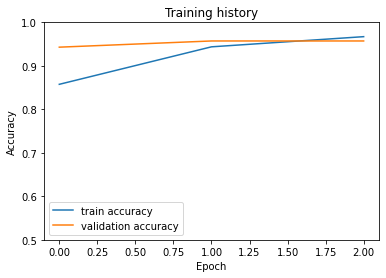

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


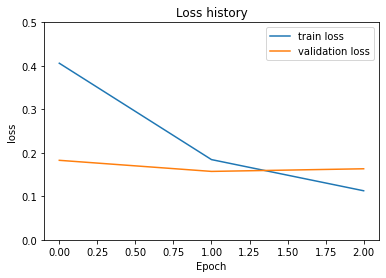

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

###0.3

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

indobenchmark/indobert-base-p1_3e-05_0.3_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.4040873790472227 accuracy 0.8720031702001189
Val   loss 0.18822731176697755 accuracy 0.9524564183835182
Time : 0:05:27
Epoch 2/3
----------
Train loss 0.1886702893888342 accuracy 0.9498712106201704
Val   loss 0.18890431249820733 accuracy 0.9508716323296355
Time : 0:05:28
Epoch 3/3
----------
Train loss 0.1239372374662316 accuracy 0.968297998811175
Val   loss 0.16649966300877778 accuracy 0.9580031695721077
Time : 0:05:28
Rata-rata akurasi train 0.9300574598771547
Rata-rata akurasi test 0.9537770734284204
CPU times: user 16min 4s, sys: 10.9 s, total: 16min 15s
Wall time: 16min 37s


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

indobenchmark/indobert-base-p1_3e-05_0.3_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8614785992217899, 0.6162556476645276)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_3e-05_0.3_3.bin
              precision    recall  f1-score   support

     edukasi       0.95      0.92      0.94       330
       tekno       0.90      0.92      0.91       218
      sports       0.98      0.96      0.97       257
      health       0.44      0.04      0.07       107
   lifestyle       0.73      0.94      0.82       373

   micro avg       0.86      0.86      0.86      1285
   macro avg       0.80      0.76      0.74      1285
weighted avg       0.84      0.86      0.83      1285
 samples avg       0.86      0.86      0.86      1285



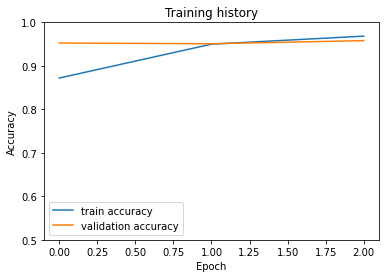

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


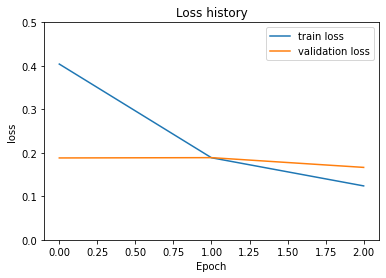

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

###0.4

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

indobenchmark/indobert-base-p1_3e-05_0.4_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.4004966161343493 accuracy 0.8640776699029126
Val   loss 0.1936889233456665 accuracy 0.9469096671949286
Time : 0:05:46
Epoch 2/3
----------
Train loss 0.18551774933061835 accuracy 0.9461065979789974
Val   loss 0.1715422857293411 accuracy 0.9500792393026941
Time : 0:05:46
Epoch 3/3
----------
Train loss 0.1112789274628062 accuracy 0.9690905488408956
Val   loss 0.1468450741641978 accuracy 0.9611727416798732
Time : 0:05:46
Rata-rata akurasi train 0.9264249389076019
Rata-rata akurasi test 0.9527205493924985
CPU times: user 16min 59s, sys: 12.8 s, total: 17min 12s
Wall time: 17min 36s


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

indobenchmark/indobert-base-p1_3e-05_0.4_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8552529182879377, 0.6007939397600296)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_3e-05_0.4_3.bin
              precision    recall  f1-score   support

     edukasi       0.96      0.91      0.93       330
       tekno       0.90      0.91      0.91       218
      sports       0.95      0.96      0.96       257
      health       0.50      0.07      0.12       107
   lifestyle       0.73      0.92      0.81       373

   micro avg       0.86      0.86      0.86      1285
   macro avg       0.81      0.76      0.75      1285
weighted avg       0.84      0.86      0.83      1285
 samples avg       0.86      0.86      0.86      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


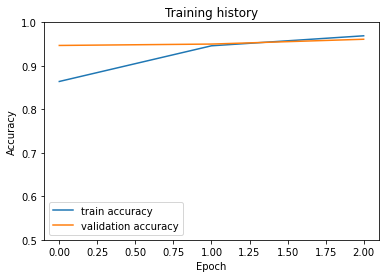

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


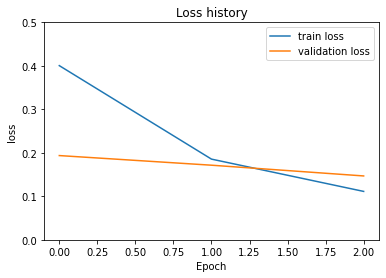

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

###0.5

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

indobenchmark/indobert-base-p1_3e-05_0.5_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.43384641281894964 accuracy 0.8618981573211809
Val   loss 0.23837098781066604 accuracy 0.938985736925515
Time : 0:09:28
Epoch 2/3
----------
Train loss 0.20549865083362248 accuracy 0.9419457103229641
Val   loss 0.17235954843838758 accuracy 0.9572107765451664
Time : 0:09:28
Epoch 3/3
----------
Train loss 0.12292349187412617 accuracy 0.9675054487814543
Val   loss 0.181653845748758 accuracy 0.9548335974643423
Time : 0:09:29
Rata-rata akurasi train 0.9237831054751998
Rata-rata akurasi test 0.9503433703116745
CPU times: user 27min 54s, sys: 19.5 s, total: 28min 14s
Wall time: 28min 37s


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

indobenchmark/indobert-base-p1_3e-05_0.5_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8544747081712062, 0.6876941998029289)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_3e-05_0.5_3.bin
              precision    recall  f1-score   support

     edukasi       0.96      0.90      0.93       330
       tekno       0.92      0.89      0.91       218
      sports       0.95      0.96      0.96       257
      health       0.60      0.08      0.15       107
   lifestyle       0.72      0.93      0.81       373

   micro avg       0.85      0.85      0.85      1285
   macro avg       0.83      0.76      0.75      1285
weighted avg       0.85      0.85      0.83      1285
 samples avg       0.85      0.85      0.85      1285



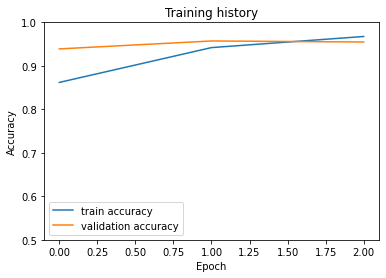

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


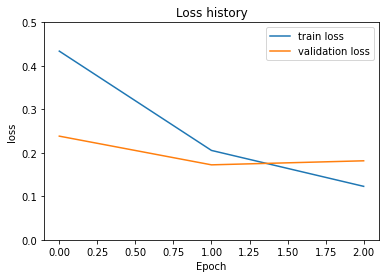

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

##4e-5

###0.1

####EPOCH 2

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

indobenchmark/indobert-base-p1_4e-05_0.1_16_2
Epoch 1/2
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.44252163901500685 accuracy 0.8591242322171587
Val   loss 0.21102043565457004 accuracy 0.9500792393026941
Time : 0:05:52
Epoch 2/2
----------
Train loss 0.21700205231421404 accuracy 0.9449177729344165
Val   loss 0.15018114209458044 accuracy 0.9572107765451664
Time : 0:05:53
Rata-rata akurasi train 0.9020210025757875
Rata-rata akurasi test 0.9536450079239303
CPU times: user 11min 31s, sys: 8.74 s, total: 11min 40s
Wall time: 11min 56s


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

indobenchmark/indobert-base-p1_4e-05_0.1_16_2


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8568093385214007, 0.5606736442258144)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_4e-05_0.1_2.bin
              precision    recall  f1-score   support

     edukasi       0.95      0.91      0.93       330
       tekno       0.95      0.87      0.91       218
      sports       0.95      0.96      0.96       257
      health       0.71      0.11      0.19       107
   lifestyle       0.72      0.94      0.81       373

   micro avg       0.86      0.86      0.86      1285
   macro avg       0.86      0.76      0.76      1285
weighted avg       0.86      0.86      0.84      1285
 samples avg       0.86      0.86      0.86      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


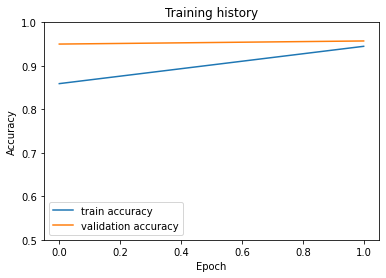

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


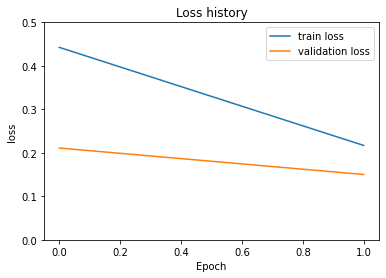

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

####EPOCH 3

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

indobenchmark/indobert-base-p1_4e-05_0.1_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.4651538495363408 accuracy 0.84802853180107
Val   loss 0.26554323955663023 accuracy 0.938985736925515
Time : 0:05:31
Epoch 2/3
----------
Train loss 0.24155574220326978 accuracy 0.939171785218942
Val   loss 0.22401869726143306 accuracy 0.945324881141046
Time : 0:05:31
Epoch 3/3
----------
Train loss 0.16554187282130028 accuracy 0.9595799484842481
Val   loss 0.20497646667888458 accuracy 0.9516640253565769
Time : 0:05:31
Rata-rata akurasi train 0.9155934218347533
Rata-rata akurasi test 0.9453248811410461
CPU times: user 16min 14s, sys: 12.2 s, total: 16min 26s
Wall time: 16min 49s


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

indobenchmark/indobert-base-p1_4e-05_0.1_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8708171206225681, 0.5290125953493479)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_4e-05_0.1_3.bin
              precision    recall  f1-score   support

     edukasi       0.95      0.92      0.93       330
       tekno       0.93      0.86      0.89       218
      sports       0.94      0.98      0.96       257
      health       0.64      0.50      0.56       107
   lifestyle       0.79      0.87      0.83       373

   micro avg       0.87      0.87      0.87      1285
   macro avg       0.85      0.83      0.84      1285
weighted avg       0.87      0.87      0.87      1285
 samples avg       0.87      0.87      0.87      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


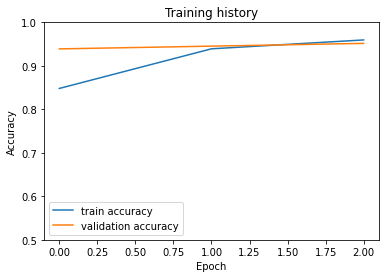

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


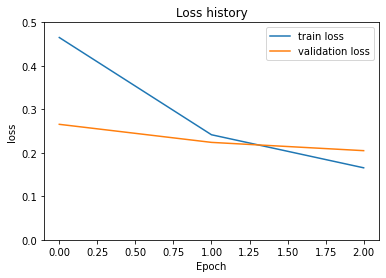

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

####EPOCH 4

######1

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

indobenchmark/indobert-base-p1_4e-05_0.1_16_4
Epoch 1/4
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.5982544379238086 accuracy 0.8076084802853181
Val   loss 0.34009950848508486 accuracy 0.904120443740095
Time : 0:05:12
Epoch 2/4
----------
Train loss 0.3237809266989367 accuracy 0.9151971468198931
Val   loss 0.24456038957909693 accuracy 0.9405705229793978
Time : 0:05:28
Epoch 3/4
----------
Train loss 0.19950001346701873 accuracy 0.9502674856350307
Val   loss 0.19445321532673662 accuracy 0.9524564183835182
Time : 0:05:30
Epoch 4/4
----------
Train loss 0.15098731623980205 accuracy 0.963344561125421
Val   loss 0.20717546395674535 accuracy 0.9477020602218701
Time : 0:05:29
Rata-rata akurasi train 0.9091044184664157
Rata-rata akurasi test 0.9362123613312203
CPU times: user 21min 9s, sys: 15.5 s, total: 21min 25s
Wall time: 21min 55s


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

indobenchmark/indobert-base-p1_4e-05_0.1_16_4


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8536964980544747, 0.6380356256390152)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_4e-05_0.1_4.bin
              precision    recall  f1-score   support

     edukasi       0.95      0.89      0.92       330
       tekno       0.91      0.88      0.89       218
      sports       0.93      0.97      0.95       257
      health       0.69      0.17      0.27       107
   lifestyle       0.73      0.92      0.82       373

   micro avg       0.86      0.85      0.85      1285
   macro avg       0.84      0.77      0.77      1285
weighted avg       0.86      0.85      0.84      1285
 samples avg       0.85      0.85      0.85      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


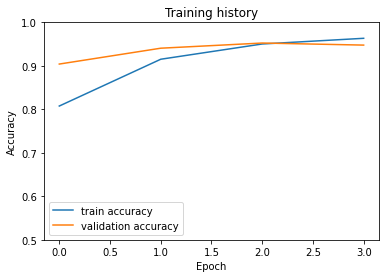

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


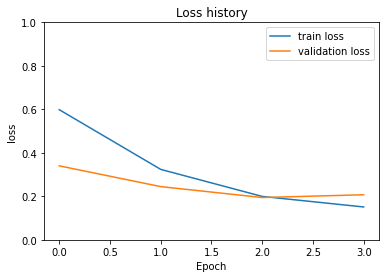

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

#####2

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

indobenchmark/indobert-base-p1_4e-05_0.1_16_4
Epoch 1/4
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.6014977616576266 accuracy 0.7984941549435308
Val   loss 0.37619547413874277 accuracy 0.8993660855784469
Time : 0:09:29
Epoch 2/4
----------
Train loss 0.36827366558033264 accuracy 0.8939964335248662
Val   loss 0.2335049533579923 accuracy 0.9255150554675119
Time : 0:09:30
Epoch 3/4
----------
Train loss 0.2279953404382767 accuracy 0.9300574598771547
Val   loss 0.21856982216144663 accuracy 0.9484944532488114
Time : 0:09:29
Epoch 4/4
----------
Train loss 0.17852107843360568 accuracy 0.9502674856350307
Val   loss 0.20288658065462037 accuracy 0.9445324881141046
Time : 0:09:29
Rata-rata akurasi train 0.8932038834951456
Rata-rata akurasi test 0.9294770206022187
CPU times: user 37min 20s, sys: 24.8 s, total: 37min 44s
Wall time: 38min 16s


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

indobenchmark/indobert-base-p1_4e-05_0.1_16_4


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8544747081712062, 0.5297493424372931)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_4e-05_0.1_4.bin
              precision    recall  f1-score   support

     edukasi       0.95      0.89      0.92       330
       tekno       0.88      0.90      0.89       218
      sports       0.94      0.96      0.95       257
      health       0.54      0.73      0.62       107
   lifestyle       0.83      0.76      0.79       373

   micro avg       0.86      0.85      0.86      1285
   macro avg       0.83      0.85      0.83      1285
weighted avg       0.87      0.85      0.86      1285
 samples avg       0.85      0.85      0.85      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


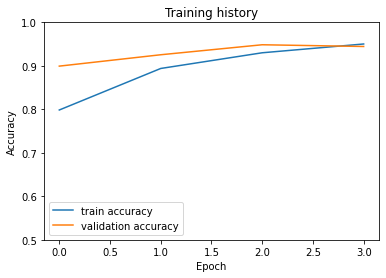

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


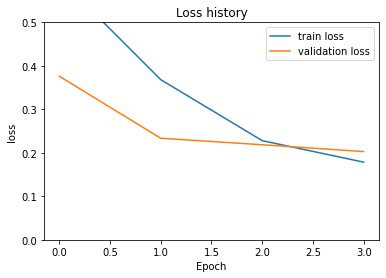

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

###0.2

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

indobenchmark/indobert-base-p1_4e-05_0.2_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.4350801122086005 accuracy 0.8599167822468793
Val   loss 0.19717267796963076 accuracy 0.9469096671949286
Time : 0:03:05
Epoch 2/3
----------
Train loss 0.23254389210480347 accuracy 0.9385773726966514
Val   loss 0.17303044803416992 accuracy 0.9572107765451664
Time : 0:03:06
Epoch 3/3
----------
Train loss 0.15250869876708056 accuracy 0.9623538735882703
Val   loss 0.15402138679394428 accuracy 0.9643423137876387
Time : 0:03:05
Rata-rata akurasi train 0.920282676177267
Rata-rata akurasi test 0.9561542525092447
CPU times: user 8min 46s, sys: 7.61 s, total: 8min 54s
Wall time: 9min 36s
Parser   : 181 ms


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

indobenchmark/indobert-base-p1_4e-05_0.2_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8474708171206226, 0.6037242845057246)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_4e-05_0.2_3.bin
              precision    recall  f1-score   support

     edukasi       0.95      0.89      0.92       330
       tekno       0.90      0.87      0.88       218
      sports       0.96      0.96      0.96       257
      health       0.62      0.05      0.09       107
   lifestyle       0.72      0.95      0.82       373

   micro avg       0.85      0.85      0.85      1285
   macro avg       0.83      0.74      0.73      1285
weighted avg       0.85      0.85      0.82      1285
 samples avg       0.85      0.85      0.85      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


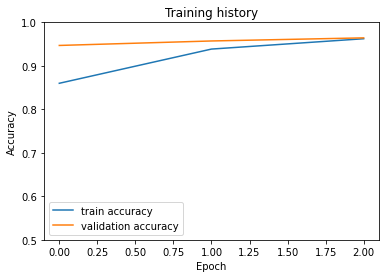

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


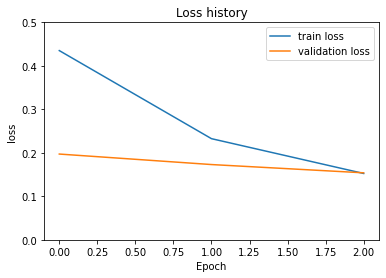

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

###0.3

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

indobenchmark/indobert-base-p1_4e-05_0.3_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.516123577834496 accuracy 0.8383197939369923
Val   loss 0.34441400288686724 accuracy 0.8993660855784469
Time : 0:05:19
Epoch 2/3
----------
Train loss 0.31303003210208935 accuracy 0.9110362591638598
Val   loss 0.19441627214745252 accuracy 0.884310618066561
Time : 0:05:37
Epoch 3/3
----------
Train loss 0.20692581207568086 accuracy 0.9423419853378244
Val   loss 0.17009104866110072 accuracy 0.9556259904912837
Time : 0:05:36
Rata-rata akurasi train 0.8972326794795588
Rata-rata akurasi test 0.9131008980454305
CPU times: user 16min 12s, sys: 11.5 s, total: 16min 23s
Wall time: 16min 44s


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

indobenchmark/indobert-base-p1_4e-05_0.3_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8552529182879377, 0.5271726553270846)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_4e-05_0.3_3.bin
              precision    recall  f1-score   support

     edukasi       0.95      0.88      0.92       330
       tekno       0.90      0.89      0.90       218
      sports       0.95      0.96      0.96       257
      health       0.57      0.45      0.50       107
   lifestyle       0.77      0.85      0.81       373

   micro avg       0.86      0.86      0.86      1285
   macro avg       0.83      0.81      0.82      1285
weighted avg       0.86      0.86      0.85      1285
 samples avg       0.86      0.86      0.86      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


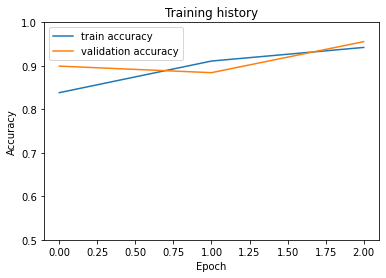

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


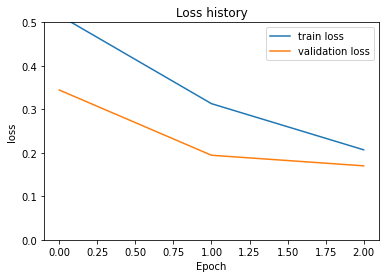

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

###0.4

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

indobenchmark/indobert-base-p1_4e-05_0.4_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.5440260169296702 accuracy 0.8274222310283337
Val   loss 0.25978024553837653 accuracy 0.927892234548336
Time : 0:05:06
Epoch 2/3
----------
Train loss 0.2912449597711144 accuracy 0.922726372102239
Val   loss 0.2232129769871318 accuracy 0.9477020602218701
Time : 0:05:09
Epoch 3/3
----------
Train loss 0.2119979178149819 accuracy 0.9510600356647514
Val   loss 0.21262955322531582 accuracy 0.9524564183835182
Time : 0:05:09
Rata-rata akurasi train 0.9004028795984413
Rata-rata akurasi test 0.9426835710512415
CPU times: user 15min 4s, sys: 12.7 s, total: 15min 17s
Wall time: 15min 41s


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

indobenchmark/indobert-base-p1_4e-05_0.4_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8669260700389105, 0.5685873924996014)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_4e-05_0.4_3.bin
              precision    recall  f1-score   support

     edukasi       0.94      0.92      0.93       330
       tekno       0.96      0.83      0.89       218
      sports       0.93      0.98      0.95       257
      health       0.64      0.46      0.53       107
   lifestyle       0.77      0.88      0.82       373

   micro avg       0.87      0.87      0.87      1285
   macro avg       0.85      0.81      0.83      1285
weighted avg       0.87      0.87      0.86      1285
 samples avg       0.87      0.87      0.87      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


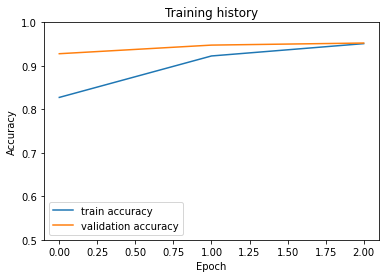

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


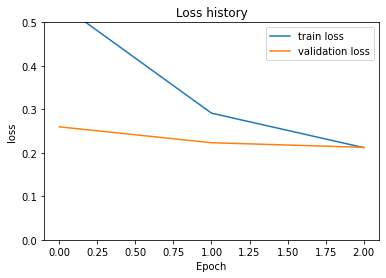

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

###0.5

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

indobenchmark/indobert-base-p1_4e-05_0.5_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.4634757160881086 accuracy 0.8563503071131365
Val   loss 0.25480933624166474 accuracy 0.9437400950871633
Time : 0:05:23
Epoch 2/3
----------
Train loss 0.24245710681558033 accuracy 0.9421438478303943
Val   loss 0.21517597918127535 accuracy 0.9484944532488114
Time : 0:05:27
Epoch 3/3
----------
Train loss 0.17813422639052606 accuracy 0.9613631860511195
Val   loss 0.19912262569782854 accuracy 0.9524564183835182
Time : 0:05:26
Rata-rata akurasi train 0.9199524469982167
Rata-rata akurasi test 0.948230322239831
CPU times: user 15min 57s, sys: 12.9 s, total: 16min 10s
Wall time: 16min 33s


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

indobenchmark/indobert-base-p1_4e-05_0.5_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8498054474708171, 0.650139712849287)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_4e-05_0.5_3.bin
              precision    recall  f1-score   support

     edukasi       0.96      0.90      0.93       330
       tekno       0.89      0.88      0.88       218
      sports       0.95      0.96      0.96       257
      health       0.36      0.04      0.07       107
   lifestyle       0.72      0.94      0.82       373

   micro avg       0.85      0.85      0.85      1285
   macro avg       0.78      0.74      0.73      1285
weighted avg       0.83      0.85      0.82      1285
 samples avg       0.85      0.85      0.85      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


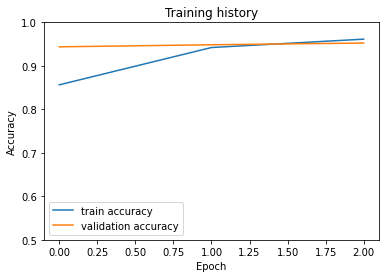

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


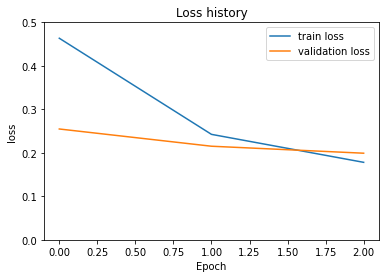

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

#END INDOBENCHMARK

#PENGUJIAN TERHADAP BERT-BASE-MULTILINGUAL-UNCASED

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      #texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      #review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(F.softmax(outputs, dim=1))
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return predictions, prediction_probs, real_values
y_pred, y_pred_probs, y_test = get_predictions(
  model,
  validasi_data_baru_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


##2e-5

###0.1

####EPOCH 2

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

bert-base-multilingual-uncased_2e-05_0.1_16_2
Epoch 1/2
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.41748742041873593 accuracy 0.8381216564295622
Val   loss 0.20818476516258302 accuracy 0.9358161648177497
Time : 0:05:21
Epoch 2/2
----------
Train loss 0.1854990094036595 accuracy 0.9413512978006736
Val   loss 0.18688763565489952 accuracy 0.9381933438985737
Time : 0:05:33
Rata-rata akurasi train 0.8897364771151179
Rata-rata akurasi test 0.9370047543581617
CPU times: user 10min 37s, sys: 14.5 s, total: 10min 51s
Wall time: 11min 29s


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

bert-base-multilingual-uncased_2e-05_0.1_16_2


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.866147859922179, 0.410169442690173)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_2e-05_0.1_2.bin
              precision    recall  f1-score   support

     edukasi       0.96      0.92      0.94       330
       tekno       0.88      0.88      0.88       218
      sports       0.95      0.96      0.96       257
      health       0.58      0.68      0.63       107
   lifestyle       0.83      0.80      0.81       373

   micro avg       0.87      0.87      0.87      1285
   macro avg       0.84      0.85      0.84      1285
weighted avg       0.88      0.87      0.87      1285
 samples avg       0.87      0.87      0.87      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


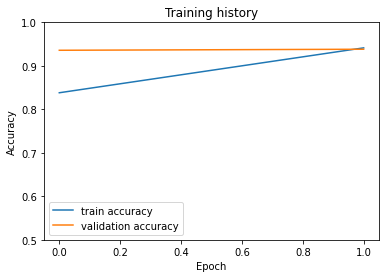

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


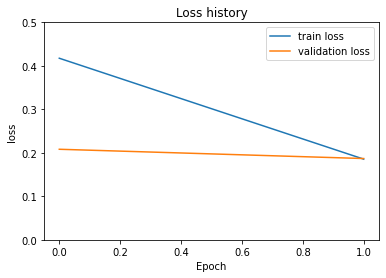

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

####EPOCH 3

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

bert-base-multilingual-uncased_2e-05_0.1_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.40092729546330114 accuracy 0.8434713691301764
Val   loss 0.1874513622974576 accuracy 0.9429477020602218
Time : 0:03:07
Epoch 2/3
----------
Train loss 0.17349819858452376 accuracy 0.9478898355458688
Val   loss 0.1809113715669211 accuracy 0.9524564183835182
Time : 0:03:08
Epoch 3/3
----------
Train loss 0.1047007779721937 accuracy 0.9700812363780463
Val   loss 0.16507615517718788 accuracy 0.9540412044374009
Time : 0:03:08
Rata-rata akurasi train 0.9204808136846973
Rata-rata akurasi test 0.9498151082937136
CPU times: user 8min 48s, sys: 10.6 s, total: 8min 59s
Wall time: 10min 13s


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

bert-base-multilingual-uncased_2e-05_0.1_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8614785992217899, 0.5242030251710849)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_2e-05_0.1_3.bin
              precision    recall  f1-score   support

     edukasi       0.96      0.89      0.92       330
       tekno       0.89      0.88      0.88       218
      sports       0.93      0.97      0.95       257
      health       0.65      0.45      0.53       107
   lifestyle       0.78      0.87      0.82       373

   micro avg       0.87      0.86      0.86      1285
   macro avg       0.84      0.81      0.82      1285
weighted avg       0.86      0.86      0.86      1285
 samples avg       0.86      0.86      0.86      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


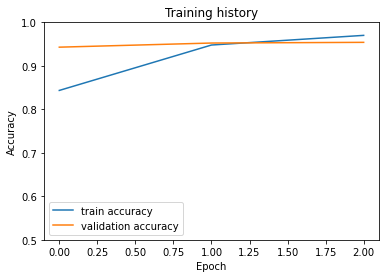

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


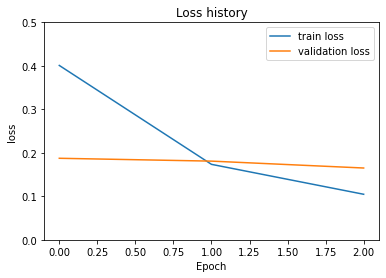

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

####EPOCH 4

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

bert-base-multilingual-uncased_2e-05_0.1_16_4
Epoch 1/4
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.4191852090880275 accuracy 0.8335644937586685
Val   loss 0.2098716738798856 accuracy 0.938985736925515
Time : 0:05:32
Epoch 2/4
----------
Train loss 0.20283256374193426 accuracy 0.9377848226669309
Val   loss 0.19911571333326306 accuracy 0.9445324881141046
Time : 0:05:36
Epoch 3/4
----------
Train loss 0.13204467721589946 accuracy 0.9613631860511195
Val   loss 0.17572732583937956 accuracy 0.9572107765451664
Time : 0:05:35
Epoch 4/4
----------
Train loss 0.08761142483025294 accuracy 0.9752328115712304
Val   loss 0.18235985711040092 accuracy 0.9540412044374009
Time : 0:05:35
Rata-rata akurasi train 0.9269863285119873
Rata-rata akurasi test 0.9486925515055468
CPU times: user 21min 41s, sys: 26.8 s, total: 22min 8s
Wall time: 23min 8s


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

bert-base-multilingual-uncased_2e-05_0.1_16_4


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8521400778210116, 0.5522043788676254)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_2e-05_0.1_4.bin
              precision    recall  f1-score   support

     edukasi       0.95      0.88      0.92       330
       tekno       0.87      0.89      0.88       218
      sports       0.94      0.98      0.96       257
      health       0.56      0.64      0.60       107
   lifestyle       0.81      0.78      0.79       373

   micro avg       0.86      0.85      0.85      1285
   macro avg       0.83      0.83      0.83      1285
weighted avg       0.86      0.85      0.86      1285
 samples avg       0.85      0.85      0.85      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


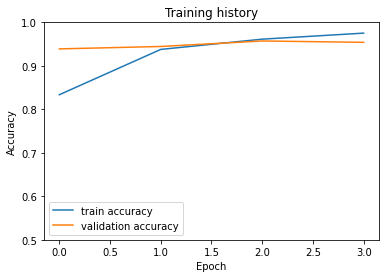

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


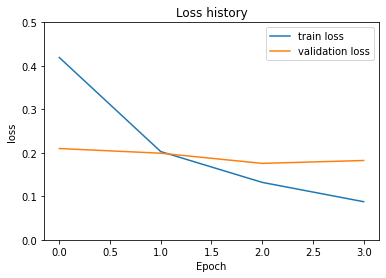

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

###0.2

####EPOCH 2

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

bert-base-multilingual-uncased_2e-05_0.2_16_2
Epoch 1/2
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.4103816434965009 accuracy 0.8521894194571032
Val   loss 0.2182750623861823 accuracy 0.9350237717908082
Time : 0:05:52
Epoch 2/2
----------
Train loss 0.19450628101866976 accuracy 0.9401624727560928
Val   loss 0.17761751869693398 accuracy 0.9469096671949286
Time : 0:05:59
Rata-rata akurasi train 0.896175946106598
Rata-rata akurasi test 0.9409667194928684
CPU times: user 11min 32s, sys: 14.2 s, total: 11min 47s
Wall time: 12min 20s


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

bert-base-multilingual-uncased_2e-05_0.2_16_2


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8560311284046692, 0.4461662704125047)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_2e-05_0.2_2.bin
              precision    recall  f1-score   support

     edukasi       0.96      0.91      0.93       330
       tekno       0.93      0.85      0.89       218
      sports       0.93      0.97      0.95       257
      health       0.62      0.36      0.45       107
   lifestyle       0.75      0.88      0.81       373

   micro avg       0.86      0.86      0.86      1285
   macro avg       0.84      0.79      0.81      1285
weighted avg       0.86      0.86      0.85      1285
 samples avg       0.86      0.86      0.86      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


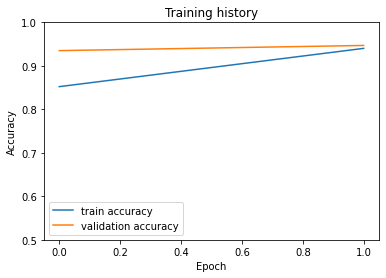

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


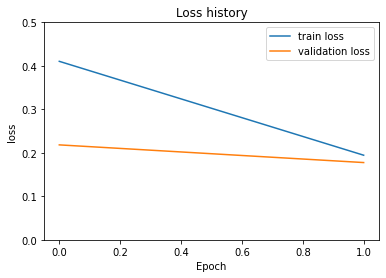

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

####EPOCH 3

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

bert-base-multilingual-uncased_2e-05_0.2_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.43023220890590663 accuracy 0.8395086189815733
Val   loss 0.23807591866536798 accuracy 0.9263074484944532
Time : 0:06:09
Epoch 2/3
----------
Train loss 0.2109465174144134 accuracy 0.9314444224291658
Val   loss 0.18895962460060853 accuracy 0.9437400950871633
Time : 0:06:11
Epoch 3/3
----------
Train loss 0.1388619456092438 accuracy 0.9575985734099465
Val   loss 0.20049472381596606 accuracy 0.945324881141046
Time : 0:06:10
Rata-rata akurasi train 0.9095172049402285
Rata-rata akurasi test 0.9384574749075542
CPU times: user 18min 4s, sys: 21.8 s, total: 18min 26s
Wall time: 19min 16s


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

bert-base-multilingual-uncased_2e-05_0.2_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8770428015564202, 0.4222758542559466)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_2e-05_0.2_3.bin
              precision    recall  f1-score   support

     edukasi       0.96      0.92      0.94       330
       tekno       0.90      0.91      0.90       218
      sports       0.95      0.96      0.96       257
      health       0.61      0.75      0.67       107
   lifestyle       0.86      0.80      0.83       373

   micro avg       0.88      0.88      0.88      1285
   macro avg       0.85      0.87      0.86      1285
weighted avg       0.89      0.88      0.88      1285
 samples avg       0.88      0.88      0.88      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


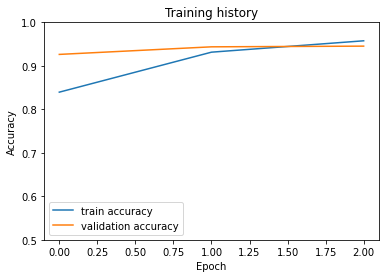

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


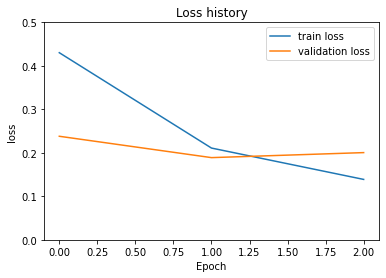

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

####EPOCH 4

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

bert-base-multilingual-uncased_2e-05_0.2_16_4
Epoch 1/4
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.4251543237073229 accuracy 0.8339607687735289
Val   loss 0.22446722923954832 accuracy 0.9270998415213946
Time : 0:09:31
Epoch 2/4
----------
Train loss 0.2151485068599776 accuracy 0.9294630473548643
Val   loss 0.18935026421765738 accuracy 0.9381933438985737
Time : 0:09:31
Epoch 3/4
----------
Train loss 0.13808726325124218 accuracy 0.958192985932237
Val   loss 0.18768992872401788 accuracy 0.9437400950871633
Time : 0:09:31
Epoch 4/4
----------
Train loss 0.08938876811792201 accuracy 0.9736477115117892
Val   loss 0.19410287771857332 accuracy 0.9508716323296355
Time : 0:09:31
Rata-rata akurasi train 0.9238161283931049
Rata-rata akurasi test 0.9399762282091918
CPU times: user 37min 12s, sys: 43.5 s, total: 37min 55s
Wall time: 39min 7s


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

bert-base-multilingual-uncased_2e-05_0.2_16_4


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8171206225680934, 0.7010863765083932)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_2e-05_0.2_4.bin
              precision    recall  f1-score   support

     edukasi       0.95      0.89      0.92       330
       tekno       0.82      0.91      0.86       218
      sports       0.77      0.97      0.86       257
      health       0.55      0.45      0.49       107
   lifestyle       0.85      0.70      0.77       373

   micro avg       0.83      0.82      0.82      1285
   macro avg       0.79      0.78      0.78      1285
weighted avg       0.83      0.82      0.82      1285
 samples avg       0.82      0.82      0.82      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


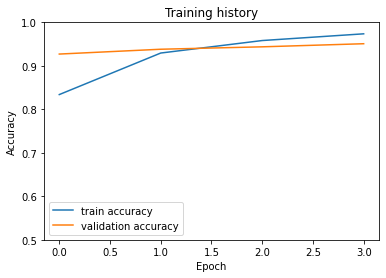

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


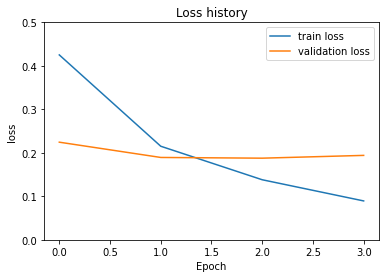

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

###0.3

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

bert-base-multilingual-uncased_2e-05_0.3_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.4170013894562763 accuracy 0.8395086189815733
Val   loss 0.22443421130198277 accuracy 0.9318541996830428
Time : 0:05:23
Epoch 2/3
----------
Train loss 0.1930154410317611 accuracy 0.9369922726372102
Val   loss 0.19045897957550573 accuracy 0.9469096671949286
Time : 0:05:31
Epoch 3/3
----------
Train loss 0.11669725511455908 accuracy 0.9637408361402814
Val   loss 0.18904411174722394 accuracy 0.9540412044374009
Time : 0:05:31
Rata-rata akurasi train 0.9134139092530216
Rata-rata akurasi test 0.9442683571051241
CPU times: user 15min 59s, sys: 25.9 s, total: 16min 25s
Wall time: 17min 19s


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

bert-base-multilingual-uncased_2e-05_0.3_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8552529182879377, 0.5393034579932264)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_2e-05_0.3_3.bin
              precision    recall  f1-score   support

     edukasi       0.95      0.89      0.92       330
       tekno       0.85      0.89      0.87       218
      sports       0.90      0.97      0.93       257
      health       0.58      0.67      0.62       107
   lifestyle       0.84      0.78      0.81       373

   micro avg       0.86      0.86      0.86      1285
   macro avg       0.83      0.84      0.83      1285
weighted avg       0.86      0.86      0.86      1285
 samples avg       0.86      0.86      0.86      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


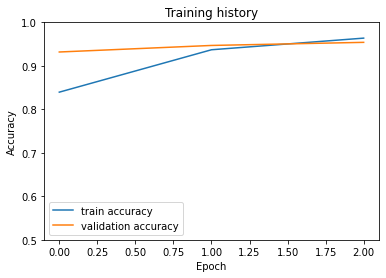

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


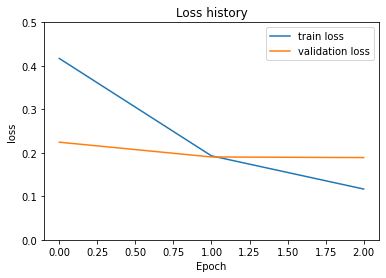

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

###0.4

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

bert-base-multilingual-uncased_2e-05_0.4_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.42787355644321895 accuracy 0.8454527442044779
Val   loss 0.21378584589243313 accuracy 0.9358161648177497
Time : 0:05:26
Epoch 2/3
----------
Train loss 0.22110002083686192 accuracy 0.9312462849217357
Val   loss 0.19484170888774568 accuracy 0.9405705229793978
Time : 0:05:36
Epoch 3/3
----------
Train loss 0.13849752096686205 accuracy 0.9603724985139687
Val   loss 0.20301969678883877 accuracy 0.9429477020602218
Time : 0:05:34
Rata-rata akurasi train 0.9123571758800608
Rata-rata akurasi test 0.9397781299524564
CPU times: user 16min 10s, sys: 21 s, total: 16min 31s
Wall time: 17min 28s


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

bert-base-multilingual-uncased_2e-05_0.4_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8552529182879377, 0.47271566010471205)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_2e-05_0.4_3.bin
              precision    recall  f1-score   support

     edukasi       0.96      0.88      0.92       330
       tekno       0.89      0.87      0.88       218
      sports       0.94      0.96      0.95       257
      health       0.61      0.51      0.56       107
   lifestyle       0.77      0.85      0.81       373

   micro avg       0.86      0.86      0.86      1285
   macro avg       0.83      0.82      0.82      1285
weighted avg       0.86      0.86      0.86      1285
 samples avg       0.86      0.86      0.86      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


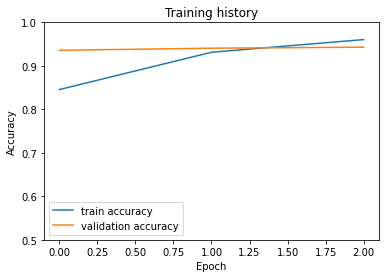

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


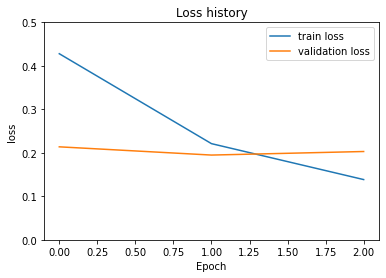

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

###0.5

####EPOCH 2

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

bert-base-multilingual-uncased_2e-05_0.5_16_2
Epoch 1/2
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.39708239622885666 accuracy 0.845650881711908
Val   loss 0.21192910344799673 accuracy 0.9421553090332805
Time : 0:05:42
Epoch 2/2
----------
Train loss 0.1868394784367042 accuracy 0.9403606102635229
Val   loss 0.18240135373500518 accuracy 0.9469096671949286
Time : 0:05:57
Rata-rata akurasi train 0.8930057459877154
Rata-rata akurasi test 0.9445324881141046
CPU times: user 11min 22s, sys: 14.5 s, total: 11min 36s
Wall time: 12min 14s


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

bert-base-multilingual-uncased_2e-05_0.5_16_2


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8529182879377432, 0.4469951108445839)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_2e-05_0.5_2.bin
              precision    recall  f1-score   support

     edukasi       0.96      0.89      0.92       330
       tekno       0.89      0.85      0.87       218
      sports       0.92      0.97      0.94       257
      health       0.55      0.79      0.65       107
   lifestyle       0.84      0.76      0.80       373

   micro avg       0.86      0.85      0.86      1285
   macro avg       0.83      0.85      0.84      1285
weighted avg       0.87      0.85      0.86      1285
 samples avg       0.85      0.85      0.85      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


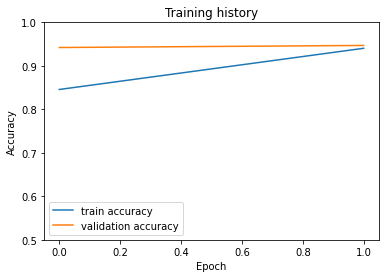

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


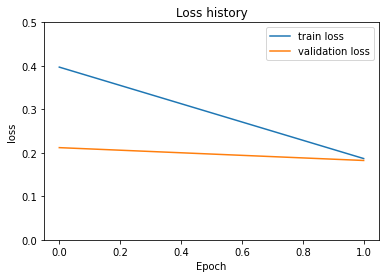

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

bert-base-multilingual-uncased_2e-05_0.5_16_2
Epoch 1/2
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.39288099022888684 accuracy 0.8484248068159302
Val   loss 0.1805665387500879 accuracy 0.9397781299524565
Time : 0:03:06
Epoch 2/2
----------
Train loss 0.170837570306008 accuracy 0.9433326728749752
Val   loss 0.17589076859522848 accuracy 0.9437400950871633
Time : 0:03:07
Rata-rata akurasi train 0.8958787398454527
Rata-rata akurasi test 0.9417591125198099
CPU times: user 5min 51s, sys: 8.81 s, total: 6min
Wall time: 6min 48s


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

bert-base-multilingual-uncased_2e-05_0.5_16_2


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8521400778210116, 0.44076133090111624)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_2e-05_0.5_2.bin
              precision    recall  f1-score   support

     edukasi       0.96      0.91      0.93       330
       tekno       0.93      0.87      0.90       218
      sports       0.94      0.96      0.95       257
      health       0.55      0.28      0.37       107
   lifestyle       0.74      0.88      0.80       373

   micro avg       0.86      0.85      0.85      1285
   macro avg       0.82      0.78      0.79      1285
weighted avg       0.85      0.85      0.85      1285
 samples avg       0.85      0.85      0.85      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


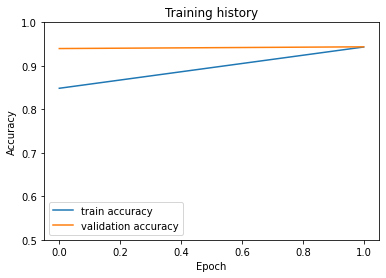

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


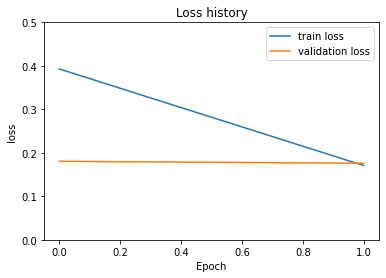

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

####EPOCH 3

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

bert-base-multilingual-uncased_2e-05_0.5_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.422277445250627 accuracy 0.8454527442044779
Val   loss 0.20388790534785653 accuracy 0.9437400950871633
Time : 0:05:15
Epoch 2/3
----------
Train loss 0.21353723097569013 accuracy 0.9346146225480484
Val   loss 0.1804597108813498 accuracy 0.9469096671949286
Time : 0:05:28
Epoch 3/3
----------
Train loss 0.13152854276166734 accuracy 0.9627501486031306
Val   loss 0.19133845142890477 accuracy 0.9524564183835182
Time : 0:05:28
Rata-rata akurasi train 0.9142725051185523
Rata-rata akurasi test 0.9477020602218701
CPU times: user 15min 45s, sys: 21.4 s, total: 16min 6s
Wall time: 16min 59s


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

bert-base-multilingual-uncased_2e-05_0.5_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8622568093385214, 0.4820196918609989)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_2e-05_0.5_3.bin
              precision    recall  f1-score   support

     edukasi       0.97      0.93      0.95       330
       tekno       0.93      0.88      0.90       218
      sports       0.95      0.96      0.96       257
      health       0.57      0.29      0.39       107
   lifestyle       0.75      0.89      0.81       373

   micro avg       0.87      0.86      0.86      1285
   macro avg       0.83      0.79      0.80      1285
weighted avg       0.86      0.86      0.86      1285
 samples avg       0.86      0.86      0.86      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


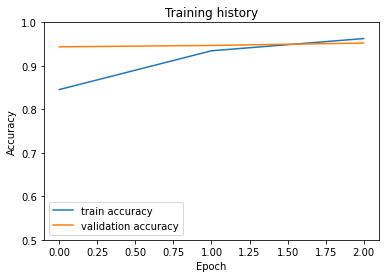

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


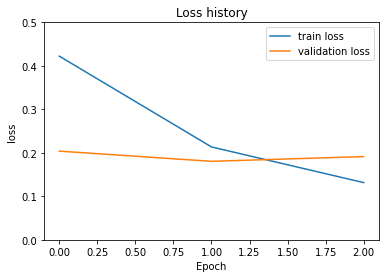

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

####EPOCH 4

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

bert-base-multilingual-uncased_2e-05_0.5_16_4
Epoch 1/4
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.4280720741924229 accuracy 0.8373291063998415
Val   loss 0.21880409671465242 accuracy 0.9286846275752774
Time : 0:05:32
Epoch 2/4
----------
Train loss 0.20845570106831485 accuracy 0.9346146225480484
Val   loss 0.17799746546941467 accuracy 0.9469096671949286
Time : 0:05:32
Epoch 3/4
----------
Train loss 0.13386990113811614 accuracy 0.9611650485436893
Val   loss 0.17511696399401733 accuracy 0.9540412044374009
Time : 0:05:32
Epoch 4/4
----------
Train loss 0.08542069006207269 accuracy 0.9756290865860907
Val   loss 0.1834055810424063 accuracy 0.9516640253565769
Time : 0:05:31
Rata-rata akurasi train 0.9271844660194175
Rata-rata akurasi test 0.945324881141046
CPU times: user 21min 32s, sys: 26.8 s, total: 21min 58s
Wall time: 23min


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

bert-base-multilingual-uncased_2e-05_0.5_16_4


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8521400778210116, 0.5975404240508609)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_2e-05_0.5_4.bin
              precision    recall  f1-score   support

     edukasi       0.94      0.92      0.93       330
       tekno       0.91      0.89      0.90       218
      sports       0.94      0.97      0.95       257
      health       0.56      0.14      0.22       107
   lifestyle       0.73      0.90      0.81       373

   micro avg       0.85      0.85      0.85      1285
   macro avg       0.82      0.76      0.76      1285
weighted avg       0.84      0.85      0.83      1285
 samples avg       0.85      0.85      0.85      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


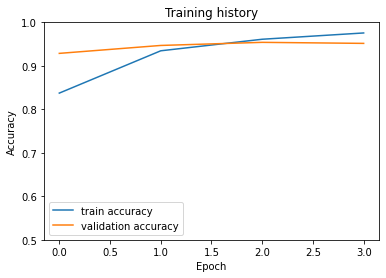

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


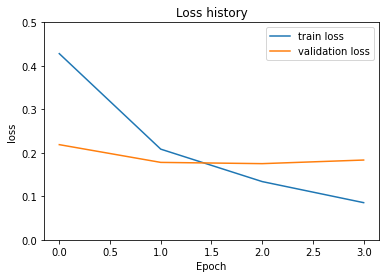

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

##3e-5

###0.1

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

bert-base-multilingual-uncased_3e-05_0.1_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.4854840995077798 accuracy 0.8230632058648703
Val   loss 0.27008635400428993 accuracy 0.9199683042789224
Time : 0:05:37
Epoch 2/3
----------
Train loss 0.22549675473695785 accuracy 0.9318406974440262
Val   loss 0.22458005464883357 accuracy 0.9374009508716323
Time : 0:05:56
Epoch 3/3
----------
Train loss 0.14854100655286892 accuracy 0.9568060233802259
Val   loss 0.23361085503821885 accuracy 0.9350237717908082
Time : 0:05:56
Rata-rata akurasi train 0.903903308896374
Rata-rata akurasi test 0.930797675647121
CPU times: user 17min 1s, sys: 20.8 s, total: 17min 22s
Wall time: 18min 6s


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

bert-base-multilingual-uncased_3e-05_0.1_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8575875486381322, 0.522128441487439)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_3e-05_0.1_3.bin
              precision    recall  f1-score   support

     edukasi       0.96      0.88      0.92       330
       tekno       0.88      0.89      0.88       218
      sports       0.94      0.97      0.95       257
      health       0.57      0.67      0.62       107
   lifestyle       0.81      0.79      0.80       373

   micro avg       0.86      0.86      0.86      1285
   macro avg       0.83      0.84      0.84      1285
weighted avg       0.86      0.86      0.86      1285
 samples avg       0.86      0.86      0.86      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


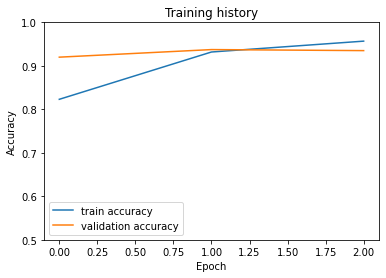

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


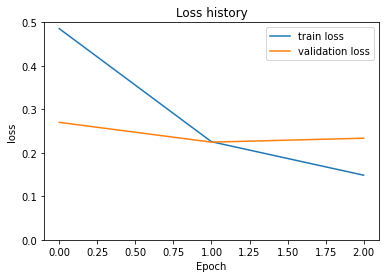

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

###0.2

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

bert-base-multilingual-uncased_3e-05_0.2_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.46960952758341085 accuracy 0.825440855954032
Val   loss 0.2348834316635245 accuracy 0.9350237717908082
Time : 0:10:22
Epoch 2/3
----------
Train loss 0.21154036078030314 accuracy 0.9348127600554785
Val   loss 0.2167872155521395 accuracy 0.9405705229793978
Time : 0:10:22
Epoch 3/3
----------
Train loss 0.12760407158506656 accuracy 0.964533386170002
Val   loss 0.23556810622162458 accuracy 0.9397781299524565
Time : 0:10:21
Rata-rata akurasi train 0.9082623340598376
Rata-rata akurasi test 0.9384574749075542
CPU times: user 30min 22s, sys: 35 s, total: 30min 57s
Wall time: 31min 38s


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

bert-base-multilingual-uncased_3e-05_0.2_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8350194552529183, 0.7262066051315079)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_3e-05_0.2_3.bin
              precision    recall  f1-score   support

     edukasi       0.94      0.92      0.93       330
       tekno       0.95      0.80      0.87       218
      sports       0.88      0.96      0.92       257
      health       0.31      0.04      0.07       107
   lifestyle       0.71      0.92      0.80       373

   micro avg       0.84      0.84      0.84      1285
   macro avg       0.76      0.73      0.72      1285
weighted avg       0.81      0.84      0.81      1285
 samples avg       0.84      0.84      0.84      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


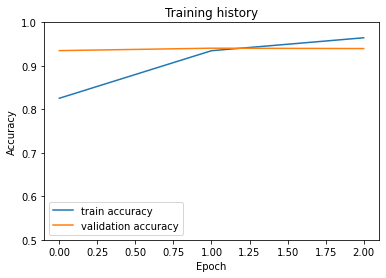

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


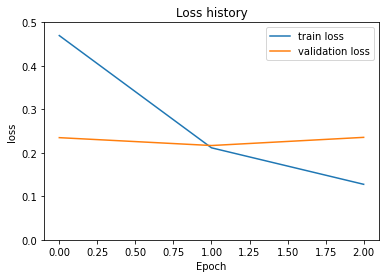

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

###0.3

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

bert-base-multilingual-uncased_3e-05_0.3_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.5367296911964688 accuracy 0.81018426788191
Val   loss 0.270128795216921 accuracy 0.9215530903328051
Time : 0:10:34
Epoch 2/3
----------
Train loss 0.25662828543918986 accuracy 0.9225282345948088
Val   loss 0.18673926569474272 accuracy 0.9381933438985737
Time : 0:10:34
Epoch 3/3
----------
Train loss 0.16334093193511798 accuracy 0.954428373291064
Val   loss 0.18516229110463417 accuracy 0.9461172741679873
Time : 0:10:32
Rata-rata akurasi train 0.8957136252559276
Rata-rata akurasi test 0.9352879027997888
CPU times: user 31min 2s, sys: 31.2 s, total: 31min 33s
Wall time: 32min 33s


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

bert-base-multilingual-uncased_3e-05_0.3_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8568093385214007, 0.4986616896959827)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_3e-05_0.3_3.bin
              precision    recall  f1-score   support

     edukasi       0.96      0.91      0.93       330
       tekno       0.94      0.89      0.92       218
      sports       0.95      0.96      0.96       257
      health       0.57      0.27      0.37       107
   lifestyle       0.74      0.88      0.80       373

   micro avg       0.86      0.86      0.86      1285
   macro avg       0.83      0.78      0.80      1285
weighted avg       0.86      0.86      0.85      1285
 samples avg       0.86      0.86      0.86      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


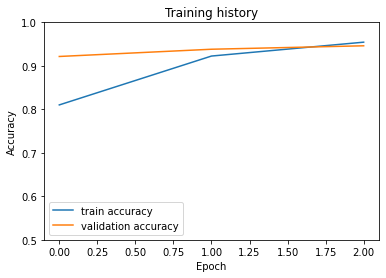

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


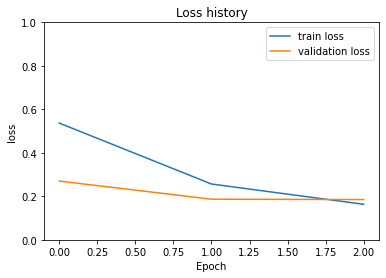

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

###0.4

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

bert-base-multilingual-uncased_3e-05_0.4_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.5279699376006198 accuracy 0.8044382801664355
Val   loss 0.30622442526436305 accuracy 0.9144215530903328
Time : 0:06:00
Epoch 2/3
----------
Train loss 0.2626731041818857 accuracy 0.9231226471170992
Val   loss 0.22780987235446332 accuracy 0.9350237717908082
Time : 0:06:03
Epoch 3/3
----------
Train loss 0.18191298032827863 accuracy 0.9488805230830196
Val   loss 0.21330050219298352 accuracy 0.9421553090332805
Time : 0:06:03
Rata-rata akurasi train 0.8921471501221848
Rata-rata akurasi test 0.9305335446381404
CPU times: user 17min 40s, sys: 26.5 s, total: 18min 6s
Wall time: 18min 56s


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

bert-base-multilingual-uncased_3e-05_0.4_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8459143968871595, 0.5411929750447104)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_3e-05_0.4_3.bin
              precision    recall  f1-score   support

     edukasi       0.96      0.91      0.93       330
       tekno       0.92      0.87      0.89       218
      sports       0.92      0.97      0.94       257
      health       0.55      0.24      0.34       107
   lifestyle       0.72      0.87      0.79       373

   micro avg       0.85      0.85      0.85      1285
   macro avg       0.81      0.77      0.78      1285
weighted avg       0.84      0.85      0.84      1285
 samples avg       0.85      0.85      0.85      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


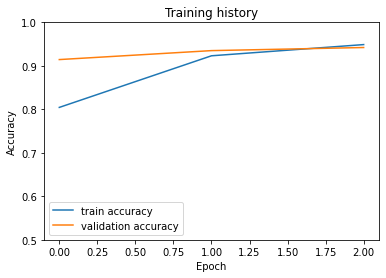

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


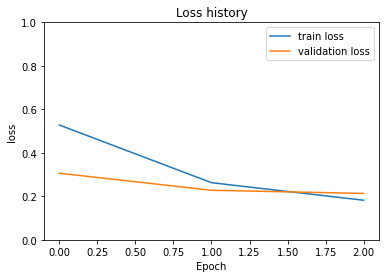

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

###0.5

####EPOCH 2

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

bert-base-multilingual-uncased_3e-05_0.5_16_2
Epoch 1/2
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.45444950414821506 accuracy 0.8185060431939766
Val   loss 0.23211629995251004 accuracy 0.9128367670364501
Time : 0:05:52
Epoch 2/2
----------
Train loss 0.21649508051208774 accuracy 0.9286704973251436
Val   loss 0.2131068934214926 accuracy 0.9342313787638669
Time : 0:05:52
Rata-rata akurasi train 0.8735882702595601
Rata-rata akurasi test 0.9235340729001584
CPU times: user 11min 26s, sys: 14.5 s, total: 11min 41s
Wall time: 12min 14s


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

bert-base-multilingual-uncased_3e-05_0.5_16_2


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8521400778210116, 0.45367714307374424)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_3e-05_0.5_2.bin
              precision    recall  f1-score   support

     edukasi       0.95      0.90      0.93       330
       tekno       0.89      0.88      0.88       218
      sports       0.94      0.96      0.95       257
      health       0.56      0.78      0.65       107
   lifestyle       0.83      0.73      0.78       373

   micro avg       0.86      0.85      0.86      1285
   macro avg       0.83      0.85      0.84      1285
weighted avg       0.87      0.85      0.86      1285
 samples avg       0.85      0.85      0.85      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


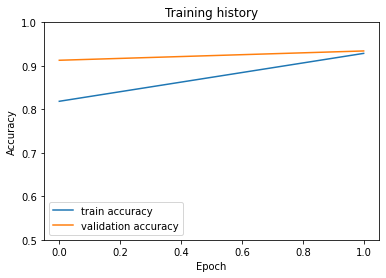

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


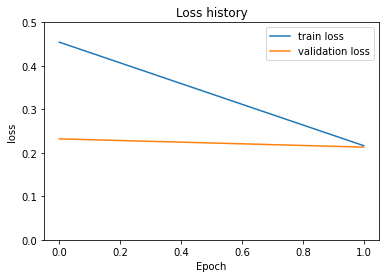

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

####EPOCH 3

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

bert-base-multilingual-uncased_3e-05_0.5_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.44898051177623055 accuracy 0.8347533188032494
Val   loss 0.23231142470495234 accuracy 0.9326465927099842
Time : 0:06:11
Epoch 2/3
----------
Train loss 0.22762874927654675 accuracy 0.9270853972657024
Val   loss 0.21651552698893262 accuracy 0.93026941362916
Time : 0:06:12
Epoch 3/3
----------
Train loss 0.15276658978708135 accuracy 0.9534376857539132
Val   loss 0.22574626428629213 accuracy 0.9334389857369255
Time : 0:06:11
Rata-rata akurasi train 0.905092133940955
Rata-rata akurasi test 0.9321183306920232
CPU times: user 18min 9s, sys: 19.7 s, total: 18min 29s
Wall time: 19min 9s


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

bert-base-multilingual-uncased_3e-05_0.5_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.867704280155642, 0.4572738844802155)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_3e-05_0.5_3.bin
              precision    recall  f1-score   support

     edukasi       0.95      0.91      0.93       330
       tekno       0.85      0.92      0.88       218
      sports       0.96      0.96      0.96       257
      health       0.63      0.63      0.63       107
   lifestyle       0.83      0.81      0.82       373

   micro avg       0.87      0.87      0.87      1285
   macro avg       0.84      0.84      0.84      1285
weighted avg       0.87      0.87      0.87      1285
 samples avg       0.87      0.87      0.87      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


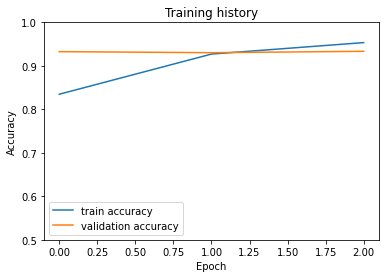

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


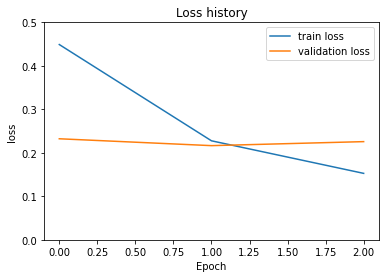

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

####EPOCH 4

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

bert-base-multilingual-uncased_3e-05_0.5_16_4
Epoch 1/4
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.5163786795662269 accuracy 0.8056271052110164
Val   loss 0.2961937022407221 accuracy 0.9215530903328051
Time : 0:05:53
Epoch 2/4
----------
Train loss 0.25646633746638847 accuracy 0.9237170596393898
Val   loss 0.2374330920438412 accuracy 0.9310618066561014
Time : 0:05:55
Epoch 3/4
----------
Train loss 0.1644327347137364 accuracy 0.9524469982167625
Val   loss 0.25051912413968974 accuracy 0.9334389857369255
Time : 0:05:54
Epoch 4/4
----------
Train loss 0.12302894704338588 accuracy 0.9667128987517337
Val   loss 0.23905204250654088 accuracy 0.9429477020602218
Time : 0:05:54
Rata-rata akurasi train 0.9121260154547256
Rata-rata akurasi test 0.9322503961965134
CPU times: user 23min 2s, sys: 29.3 s, total: 23min 31s
Wall time: 24min 46s


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

bert-base-multilingual-uncased_3e-05_0.5_16_4


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8513618677042801, 0.5810345720182127)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_3e-05_0.5_4.bin
              precision    recall  f1-score   support

     edukasi       0.97      0.88      0.92       330
       tekno       0.80      0.91      0.85       218
      sports       0.94      0.96      0.95       257
      health       0.58      0.71      0.64       107
   lifestyle       0.83      0.76      0.79       373

   micro avg       0.85      0.85      0.85      1285
   macro avg       0.82      0.84      0.83      1285
weighted avg       0.86      0.85      0.85      1285
 samples avg       0.85      0.85      0.85      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


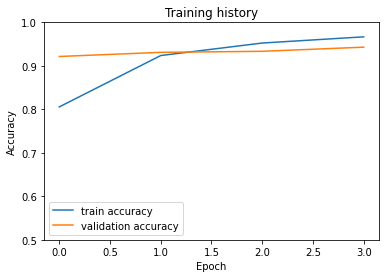

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


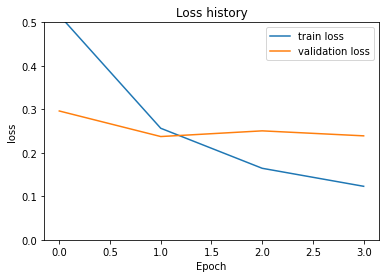

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

##5e-5

###0.1

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

bert-base-multilingual-uncased_5e-05_0.1_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.8050751386894078 accuracy 0.6699029126213593
Val   loss 0.660961628526072 accuracy 0.7939778129952456
Time : 0:05:47
Epoch 2/3
----------
Train loss 0.49526263207574434 accuracy 0.8424806815930256
Val   loss 0.3609978925271691 accuracy 0.881933438985737
Time : 0:05:53
Epoch 3/3
----------
Train loss 0.3396808182867833 accuracy 0.8987517337031901
Val   loss 0.27076949304134784 accuracy 0.9239302694136292
Time : 0:05:50
Rata-rata akurasi train 0.8037117759725249
Rata-rata akurasi test 0.8666138404648706
CPU times: user 17min, sys: 22.5 s, total: 17min 22s
Wall time: 18min 19s


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

bert-base-multilingual-uncased_5e-05_0.1_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8194552529182879, 0.6376324588041983)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_5e-05_0.1_3.bin
              precision    recall  f1-score   support

     edukasi       0.94      0.87      0.90       330
       tekno       0.92      0.82      0.87       218
      sports       0.94      0.93      0.93       257
      health       0.49      0.62      0.55       107
   lifestyle       0.72      0.76      0.74       373

   micro avg       0.82      0.82      0.82      1285
   macro avg       0.80      0.80      0.80      1285
weighted avg       0.84      0.82      0.83      1285
 samples avg       0.82      0.82      0.82      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


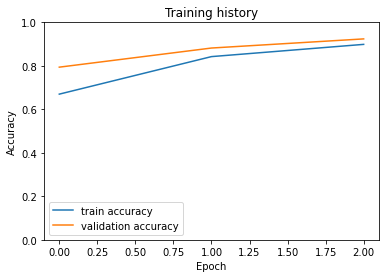

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);


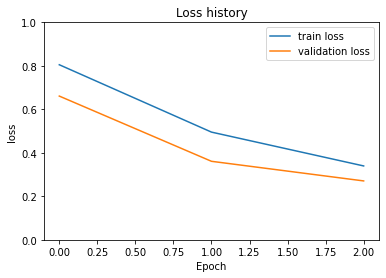

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

###0.2

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

bert-base-multilingual-uncased_5e-05_0.2_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.9891309854869224 accuracy 0.5163463443629879
Val   loss 0.6889220846793319 accuracy 0.8232963549920761
Time : 0:05:49
Epoch 2/3
----------
Train loss 0.6549697507502912 accuracy 0.7755102040816326
Val   loss 0.44207714790407615 accuracy 0.8803486529318542
Time : 0:05:54
Epoch 3/3
----------
Train loss 0.430870371705652 accuracy 0.8836932831384982
Val   loss 0.4209884292434288 accuracy 0.8787638668779715
Time : 0:05:55
Rata-rata akurasi train 0.7251832771943728
Rata-rata akurasi test 0.8608029582673006
CPU times: user 17min 9s, sys: 20.8 s, total: 17min 30s
Wall time: 18min 15s


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

bert-base-multilingual-uncased_5e-05_0.2_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.7618677042801556, 0.7476194715012371)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_5e-05_0.2_3.bin
              precision    recall  f1-score   support

     edukasi       0.94      0.71      0.80       330
       tekno       0.82      0.86      0.84       218
      sports       0.96      0.83      0.89       257
      health       0.37      0.67      0.48       107
   lifestyle       0.75      0.73      0.74       373

   micro avg       0.78      0.76      0.77      1285
   macro avg       0.77      0.76      0.75      1285
weighted avg       0.82      0.76      0.78      1285
 samples avg       0.76      0.76      0.76      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


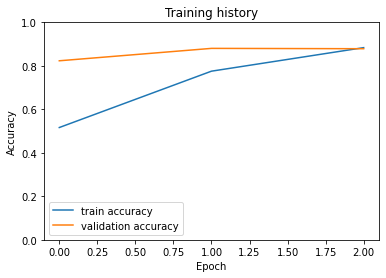

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);


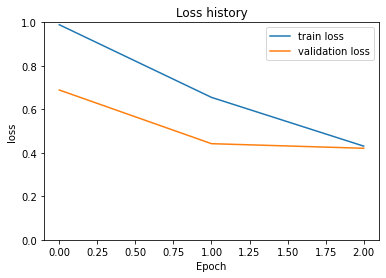

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

###0.3

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

bert-base-multilingual-uncased_5e-05_0.3_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.5961370279517355 accuracy 0.7868040420051515
Val   loss 0.4370966049359192 accuracy 0.9025356576862124
Time : 0:09:36
Epoch 2/3
----------
Train loss 0.3425832566321839 accuracy 0.9096492966118486
Val   loss 0.2839460111329261 accuracy 0.93026941362916
Time : 0:09:36
Epoch 3/3
----------
Train loss 0.2463031161334837 accuracy 0.9361997226074896
Val   loss 0.2748688003284079 accuracy 0.9294770206022187
Time : 0:10:31
Rata-rata akurasi train 0.8775510204081632
Rata-rata akurasi test 0.9207606973058636
CPU times: user 29min 1s, sys: 31.1 s, total: 29min 32s
Wall time: 30min 14s


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

bert-base-multilingual-uncased_5e-05_0.3_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8272373540856031, 0.6471541618244193)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_5e-05_0.3_3.bin
              precision    recall  f1-score   support

     edukasi       0.96      0.85      0.91       330
       tekno       0.90      0.87      0.88       218
      sports       0.98      0.92      0.95       257
      health       0.35      0.08      0.14       107
   lifestyle       0.68      0.93      0.78       373

   micro avg       0.83      0.83      0.83      1285
   macro avg       0.77      0.73      0.73      1285
weighted avg       0.82      0.83      0.81      1285
 samples avg       0.83      0.83      0.83      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


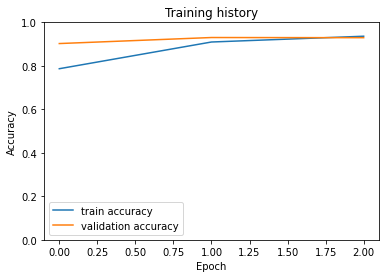

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);


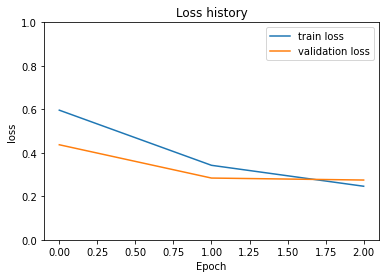

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

###0.4

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

bert-base-multilingual-uncased_5e-05_0.4_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 1.1927331281425078 accuracy 0.28056271052110165
Val   loss 1.1329487524455106 accuracy 0.13708399366085577
Time : 0:05:16
Epoch 2/3
----------
Train loss 0.538260782821269 accuracy 0.8036457301367149
Val   loss 0.36637314409017563 accuracy 0.9001584786053882
Time : 0:05:17
Epoch 3/3
----------
Train loss 0.29001806480102715 accuracy 0.9163859718644739
Val   loss 0.2951916536858565 accuracy 0.9175911251980983
Time : 0:05:16
Rata-rata akurasi train 0.6668648041740969
Rata-rata akurasi test 0.6516111991547807
CPU times: user 15min 23s, sys: 21.5 s, total: 15min 45s
Wall time: 16min 36s


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

bert-base-multilingual-uncased_5e-05_0.4_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8070038910505837, 0.6144421954328815)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_5e-05_0.4_3.bin
              precision    recall  f1-score   support

     edukasi       0.93      0.89      0.91       330
       tekno       0.91      0.83      0.87       218
      sports       0.93      0.92      0.92       257
      health       0.46      0.82      0.59       107
   lifestyle       0.76      0.64      0.69       373

   micro avg       0.81      0.81      0.81      1285
   macro avg       0.79      0.82      0.80      1285
weighted avg       0.83      0.81      0.81      1285
 samples avg       0.81      0.81      0.81      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


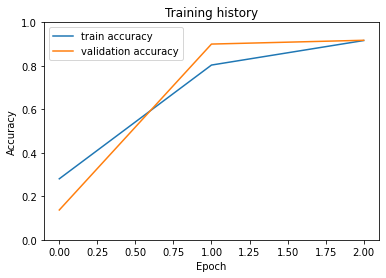

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);


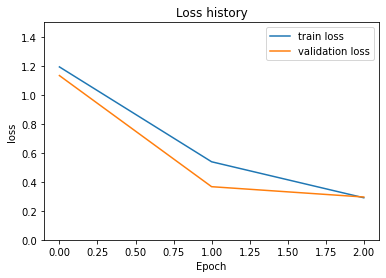

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1.5]);

###0.5

In [ ]:
%%time
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    best_accuracy = test_acc

bert-base-multilingual-uncased_5e-05_0.5_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.6154194133874925 accuracy 0.7709530414107391
Val   loss 0.34372706007495335 accuracy 0.8882725832012678
Time : 0:05:49
Epoch 2/3
----------
Train loss 0.32235341031351894 accuracy 0.9027144838517931
Val   loss 0.23793278422348108 accuracy 0.9215530903328051
Time : 0:05:53
Epoch 3/3
----------
Train loss 0.20350820841149816 accuracy 0.9383792351892213
Val   loss 0.24462460414093884 accuracy 0.927892234548336
Time : 0:05:53
Rata-rata akurasi train 0.8706822534839178
Rata-rata akurasi test 0.9125726360274697
CPU times: user 17min 7s, sys: 22.1 s, total: 17min 29s
Wall time: 18min 27s


In [ ]:
print(f'{PRE_TRAINED_MODEL_BAHASA}_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

bert-base-multilingual-uncased_5e-05_0.5_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8389105058365759, 0.5195914608322911)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_5e-05_0.5_3.bin
              precision    recall  f1-score   support

     edukasi       0.95      0.90      0.92       330
       tekno       0.86      0.86      0.86       218
      sports       0.89      0.96      0.93       257
      health       0.55      0.72      0.62       107
   lifestyle       0.83      0.72      0.77       373

   micro avg       0.85      0.84      0.84      1285
   macro avg       0.82      0.83      0.82      1285
weighted avg       0.85      0.84      0.84      1285
 samples avg       0.84      0.84      0.84      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


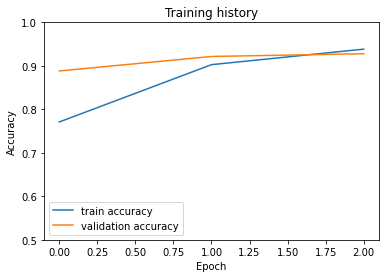

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


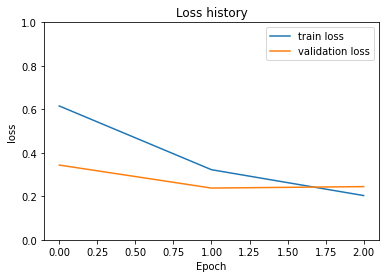

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

#END BERT-MULTILINGUAL-UNCASED

In [ ]:
%%time
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save({
            'epoch': EPOCHS,
            'dropout': DROPOUT,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_len': MAX_LEN,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_acc': train_acc,
            'train_loss': train_loss,
            'test_acc': test_acc,
            'test_loss': test_loss
            }, path)
    best_accuracy = test_acc

softmax_layer_1e-05_0.1_8_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.3447015915090357 accuracy 0.8801268080047553
Val   loss 0.1688501667570252 accuracy 0.9500792393026941
Time : 0:05:41
Epoch 2/3
----------
Train loss 0.16950005757114694 accuracy 0.9526451357241926
Val   loss 0.15499573214498313 accuracy 0.9587955625990491
Time : 0:05:52
Epoch 3/3
----------
Train loss 0.12104713071688195 accuracy 0.9673073112740241
Val   loss 0.15087700972651852 accuracy 0.9627575277337559
Time : 0:05:52
Rata-rata akurasi train 0.9333597516676574
Rata-rata akurasi test 0.9572107765451664
CPU times: user 17min, sys: 19.4 s, total: 17min 19s
Wall time: 17min 42s


In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_loader,
  loss_fn,
  device
)
acc, loss

softmax_layer_1e-05_0.1_8_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8677494199535963, 0.6507828824310478)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_1e-05_0.1_3.bin
              precision    recall  f1-score   support

     edukasi       0.92      0.90      0.91       123
       tekno       0.90      0.85      0.88        87
      sports       1.00      0.97      0.99        72
      health       0.25      0.04      0.07        26
   lifestyle       0.77      0.96      0.86       123

   micro avg       0.87      0.87      0.87       431
   macro avg       0.77      0.74      0.74       431
weighted avg       0.85      0.87      0.85       431
 samples avg       0.87      0.87      0.87       431



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
PRE_TRAINED_MODEL_BAHASA =  'indobenchmark/indobert-base-p1'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_BAHASA)

checkpoint = torch.load(load_path, map_location=torch.device('cpu'))

EPOCH = checkpoint['epoch']
DROPOUT = checkpoint['dropout']
BATCH_SIZE = checkpoint['batch_size']
MAX_LEN = checkpoint['max_len']
LEARNING_RATE = checkpoint['learning_rate']
train_acc = checkpoint['train_acc']
train_loss = checkpoint['train_loss']
test_acc = checkpoint['test_acc']
test_loss = checkpoint['test_loss']
model = Klasifikasi(5, DROPOUT)
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


#MAX_LEN = 400
#BATCH_SIZE = 16

In [ ]:
train_acc

TypeError: ignored

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      #texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      #review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(F.softmax(outputs, dim=1))
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return predictions, prediction_probs, real_values
y_pred, y_pred_probs, y_test = get_predictions(
  model,
  validasi_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
%%time
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save(model.state_dict(), path)
    best_accuracy = test_acc

softmax_layer_1e-05_0.2_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.2996089974521354 accuracy 0.8830814961605152
Val   loss 0.18554958311869996 accuracy 0.9297029702970298
Time : 0:04:29
Epoch 2/3
----------
Train loss 0.13078101531633732 accuracy 0.9541738915035918
Val   loss 0.20454000340760103 accuracy 0.9346534653465347
Time : 0:04:34
Epoch 3/3
----------
Train loss 0.07538209231193048 accuracy 0.9732474609858806
Val   loss 0.19305206142144016 accuracy 0.9425742574257425
Time : 0:04:34
Rata-rata akurasi train 0.936834282883329
Rata-rata akurasi test 0.9356435643564357
CPU times: user 13min 19s, sys: 8.61 s, total: 13min 28s
Wall time: 13min 42s


In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_loader,
  loss_fn,
  device
)
acc, loss

softmax_layer_1e-05_0.2_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.9611727416798732, 0.12837356690441176)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_1e-05_0.2_3.bin
              precision    recall  f1-score   support

     edukasi       0.99      0.97      0.98       192
       tekno       0.96      0.95      0.95       189
      sports       1.00      0.99      0.99       444
      health       0.91      0.77      0.83        78
   lifestyle       0.92      0.97      0.94       359

   micro avg       0.96      0.96      0.96      1262
   macro avg       0.95      0.93      0.94      1262
weighted avg       0.96      0.96      0.96      1262
 samples avg       0.96      0.96      0.96      1262



In [ ]:
%%time
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save(model.state_dict(), path)
    best_accuracy = test_acc

softmax_layer_2e-05_0.2_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.3395410013374074 accuracy 0.8823383700767897
Val   loss 0.19638981227762997 accuracy 0.9316831683168317
Time : 0:04:22
Epoch 2/3
----------
Train loss 0.15594879389103694 accuracy 0.9521922219469904
Val   loss 0.21448894989589462 accuracy 0.9316831683168317
Time : 0:04:29
Epoch 3/3
----------
Train loss 0.08868590140072886 accuracy 0.9737428783750309
Val   loss 0.20684226164121355 accuracy 0.9415841584158415
Time : 0:04:29
Rata-rata akurasi train 0.9360911567996038
Rata-rata akurasi test 0.9349834983498351
CPU times: user 13min 3s, sys: 7.98 s, total: 13min 11s
Wall time: 13min 31s


In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_loader,
  loss_fn,
  device
)
acc, loss

softmax_layer_2e-05_0.2_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.9595879556259905, 0.1488517814704889)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_2e-05_0.2_3.bin
              precision    recall  f1-score   support

     edukasi       0.98      0.97      0.98       192
       tekno       0.98      0.95      0.96       189
      sports       1.00      0.99      0.99       444
      health       0.88      0.73      0.80        78
   lifestyle       0.91      0.97      0.94       359

   micro avg       0.96      0.96      0.96      1262
   macro avg       0.95      0.92      0.93      1262
weighted avg       0.96      0.96      0.96      1262
 samples avg       0.96      0.96      0.96      1262



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
%%time
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save(model.state_dict(), path)
    best_accuracy = test_acc

softmax_layer_3e-05_0.2_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.4309326463448907 accuracy 0.8612831310378994
Val   loss 0.2808775709781912 accuracy 0.9158415841584159
Time : 0:04:14
Epoch 2/3
----------
Train loss 0.22038204935397732 accuracy 0.9415407480802577
Val   loss 0.2367442685754213 accuracy 0.9376237623762376
Time : 0:04:18
Epoch 3/3
----------
Train loss 0.1328299327637529 accuracy 0.9648253653703245
Val   loss 0.24813458485914452 accuracy 0.9415841584158415
Time : 0:04:18
Rata-rata akurasi train 0.9225497481628272
Rata-rata akurasi test 0.9316831683168316
CPU times: user 12min 33s, sys: 8.75 s, total: 12min 42s
Wall time: 12min 56s


In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_loader,
  loss_fn,
  device
)
acc, loss

softmax_layer_3e-05_0.2_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.9492868462757528, 0.18820459516483207)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_3e-05_0.2_3.bin
              precision    recall  f1-score   support

     edukasi       0.98      0.97      0.97       192
       tekno       0.97      0.95      0.96       189
      sports       0.99      0.99      0.99       444
      health       0.84      0.67      0.74        78
   lifestyle       0.89      0.96      0.92       359

   micro avg       0.95      0.95      0.95      1262
   macro avg       0.93      0.90      0.92      1262
weighted avg       0.95      0.95      0.95      1262
 samples avg       0.95      0.95      0.95      1262



In [ ]:
%%time
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save(model.state_dict(), path)
    best_accuracy = test_acc

softmax_layer_4e-05_0.2_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.7287292445130028 accuracy 0.7042358186772356
Val   loss 0.4499075474886922 accuracy 0.8683168316831683
Time : 0:02:26
Epoch 2/3
----------
Train loss 0.3525973037621485 accuracy 0.897944017835026
Val   loss 0.3094085353804985 accuracy 0.9089108910891089
Time : 0:02:25
Epoch 3/3
----------
Train loss 0.2378777646801983 accuracy 0.9348526133267278
Val   loss 0.290234118612716 accuracy 0.9277227722772278
Time : 0:02:25
Rata-rata akurasi train 0.8456774832796632
Rata-rata akurasi test 0.9016501650165017
CPU times: user 7min 5s, sys: 2.89 s, total: 7min 8s
Wall time: 7min 21s


In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_loader,
  loss_fn,
  device
)
acc, loss

softmax_layer_4e-05_0.2_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.9429477020602218, 0.2157680382834205)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_4e-05_0.2_3.bin
              precision    recall  f1-score   support

     edukasi       0.97      0.96      0.97       192
       tekno       0.96      0.95      0.95       189
      sports       0.99      0.99      0.99       444
      health       0.75      0.73      0.74        78
   lifestyle       0.90      0.92      0.91       359

   micro avg       0.94      0.94      0.94      1262
   macro avg       0.91      0.91      0.91      1262
weighted avg       0.94      0.94      0.94      1262
 samples avg       0.94      0.94      0.94      1262



In [ ]:
%%time
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save(model.state_dict(), path)
    best_accuracy = test_acc

softmax_layer_5e-05_0.2_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.781879027193714 accuracy 0.6814466187763191
Val   loss 0.6981293628487037 accuracy 0.7544554455445545
Time : 0:08:07
Epoch 2/3
----------
Train loss 0.6933385096637628 accuracy 0.6881347535298489
Val   loss 0.648383274441585 accuracy 0.7643564356435644
Time : 0:08:06
Epoch 3/3
----------
Train loss 0.6518987537961703 accuracy 0.7473371315333168
Val   loss 0.6239122158149257 accuracy 0.7712871287128713
Time : 0:08:06
Rata-rata akurasi train 0.7056395012798283
Rata-rata akurasi test 0.7633663366336633
CPU times: user 23min 55s, sys: 13.9 s, total: 24min 9s
Wall time: 24min 25s


In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_loader,
  loss_fn,
  device
)
acc, loss

softmax_layer_5e-05_0.2_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.7670364500792393, 0.5965934961656981)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_5e-05_0.2_3.bin
              precision    recall  f1-score   support

     edukasi       0.95      0.97      0.96       192
       tekno       0.00      0.00      0.00       189
      sports       0.99      0.96      0.98       444
      health       0.00      0.00      0.00        78
   lifestyle       0.56      0.99      0.71       359

   micro avg       0.77      0.77      0.77      1262
   macro avg       0.50      0.58      0.53      1262
weighted avg       0.65      0.77      0.69      1262
 samples avg       0.77      0.77      0.77      1262



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
%%time
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Test  loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  '''
  5.56
  11.51
  
  '''

  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi train {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save(model.state_dict(), path)
    best_accuracy = test_acc

softmax_layer_1e-05_0.2_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.31228602938855043 accuracy 0.8789379829601743
Test  loss 0.15508435190584557 accuracy 0.9556259904912837
Epoch 2/3
----------
Train loss 0.1428537397067758 accuracy 0.9530414107390529
Test  loss 0.14941716543251438 accuracy 0.9540412044374009
Epoch 3/3
----------
Train loss 0.08486296495023372 accuracy 0.9750346740638003
Test  loss 0.15425536424640707 accuracy 0.9492868462757528
Rata-rata akurasi train 0.9356713559210093
Rata-rata akurasi train 0.9529846804014791
CPU times: user 17min 47s, sys: 9.33 s, total: 17min 57s
Wall time: 18min 10s


In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_loader,
  loss_fn,
  device
)
acc, loss

softmax_layer_1e-05_0.2_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8840466926070039, 0.42212237179693246)

In [ ]:
%%time
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Test  loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  '''
  5.38
  11.25
  
  '''

  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi train {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save(model.state_dict(), f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}.bin')
    best_accuracy = test_acc

softmax_layer_2e-05_0.2_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.3315049260839985 accuracy 0.8850802456905092
Test  loss 0.1910850186684888 accuracy 0.9421553090332805
Epoch 2/3
----------
Train loss 0.1436601963429859 accuracy 0.9574004359025163
Test  loss 0.1665093371220216 accuracy 0.9548335974643423
Epoch 3/3
----------
Train loss 0.07785381306894124 accuracy 0.9774123241529622
Test  loss 0.16839818039738066 accuracy 0.9572107765451664
Rata-rata akurasi train 0.9399643352486627
Rata-rata akurasi train 0.9513998943475963
CPU times: user 16min 50s, sys: 10.3 s, total: 17min 1s
Wall time: 17min 14s


In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_loader,
  loss_fn,
  device
)
acc, loss

softmax_layer_2e-05_0.2_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8700696055684455, 0.5333765289677238)

In [ ]:
%%time
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Test  loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  '''
  5.49
  11.45
  
  '''

  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi train {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save(model.state_dict(), f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}.bin')
    best_accuracy = test_acc

softmax_layer_3e-05_0.2_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.4169945071415999 accuracy 0.859520507232019
Test  loss 0.21005827627038653 accuracy 0.945324881141046
Epoch 2/3
----------
Train loss 0.20494471172083029 accuracy 0.9409550227858133
Test  loss 0.1727920352669928 accuracy 0.9516640253565769
Epoch 3/3
----------
Train loss 0.12418759340063751 accuracy 0.9641371111551417
Test  loss 0.1591466886840195 accuracy 0.9532488114104596
Rata-rata akurasi train 0.921537547057658
Rata-rata akurasi train 0.9500792393026941
CPU times: user 17min 18s, sys: 10.8 s, total: 17min 29s
Wall time: 17min 43s


In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_loader,
  loss_fn,
  device
)
acc, loss

softmax_layer_3e-05_0.2_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8631090487238979, 0.4643361877856983)

In [ ]:
%%time
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Test  loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  '''
  5.49
  11.45
  
  '''

  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi train {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save(model.state_dict(), f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}.bin')
    best_accuracy = test_acc

softmax_layer_4e-05_0.2_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.6334456961389773 accuracy 0.7903705171388944
Test  loss 0.5407886224079735 accuracy 0.7416798732171157
Epoch 2/3
----------
Train loss 0.30792512805672667 accuracy 0.9140083217753121
Test  loss 0.23148698096835538 accuracy 0.9342313787638669
Epoch 3/3
----------
Train loss 0.21929610125820706 accuracy 0.9419457103229641
Test  loss 0.21154038512584153 accuracy 0.9421553090332805
Rata-rata akurasi train 0.8821081830790569
Rata-rata akurasi train 0.8726888536714209
CPU times: user 16min 20s, sys: 10.8 s, total: 16min 31s
Wall time: 16min 45s


In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_loader,
  loss_fn,
  device
)
acc, loss

softmax_layer_4e-05_0.2_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8816705336426914, 0.4137591474034168)

In [ ]:
%%time
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Test  loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  '''
  5.49
  11.45
  
  '''

  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi train {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save(model.state_dict(), f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}.bin')
    best_accuracy = test_acc

softmax_layer_5e-05_0.2_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.7993261937193478 accuracy 0.6017436100653853
Test  loss 0.6725384774087351 accuracy 0.5396196513470681
Epoch 2/3
----------
Train loss 0.5701275013528669 accuracy 0.6825837130968893
Test  loss 0.466154124729241 accuracy 0.8082408874801902
Epoch 3/3
----------
Train loss 0.5020738899283395 accuracy 0.7128987517337032
Test  loss 0.4622055183671698 accuracy 0.6608557844690967
Rata-rata akurasi train 0.665742024965326
Rata-rata akurasi train 0.6695721077654516
CPU times: user 15min 31s, sys: 9.69 s, total: 15min 41s
Wall time: 15min 54s


In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_loader,
  loss_fn,
  device
)
acc, loss

softmax_layer_5e-05_0.2_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.4176334106728538, 0.8866886640036548)

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      #texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      #review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(F.softmax(outputs, dim=1))
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return predictions, prediction_probs, real_values

In [ ]:
%%time
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save(model.state_dict(), f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}.bin')
    best_accuracy = test_acc

softmax_layer_1e-05_0.2_16_4
Epoch 1/4
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.32206277771487457 accuracy 0.8836932831384982
Val   loss 0.16438116143823048 accuracy 0.9477020602218701
Time : 0:05:40
Epoch 2/4
----------
Train loss 0.14274320468347804 accuracy 0.9554190608282148
Val   loss 0.15628809413188904 accuracy 0.9556259904912837
Time : 0:05:39
Epoch 3/4
----------
Train loss 0.09346259476600768 accuracy 0.973449574004359
Val   loss 0.1606819176504129 accuracy 0.9556259904912837
Time : 0:05:40
Epoch 4/4
----------
Train loss 0.06603717100194985 accuracy 0.9821676243312859
Val   loss 0.17350433470940665 accuracy 0.9540412044374009
Time : 0:05:39
Rata-rata akurasi train 0.9486823855755895
Rata-rata akurasi test 0.9532488114104596
CPU times: user 22min 10s, sys: 13.1 s, total: 22min 23s
Wall time: 22min 41s
Parser   : 159 ms


In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_loader,
  loss_fn,
  device
)
acc, loss
y_pred, y_pred_probs, y_test = get_predictions(
  model,
  validasi_data_loader
)

softmax_layer_1e-05_0.2_16_4


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8529182879377432, 0.5978159511197404)

In [ ]:
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

              precision    recall  f1-score   support

     edukasi       0.94      0.92      0.93       330
       tekno       0.86      0.89      0.87       218
      sports       0.96      0.96      0.96       257
      health       0.59      0.21      0.32       107
   lifestyle       0.75      0.88      0.81       373

   micro avg       0.86      0.85      0.85      1285
   macro avg       0.82      0.77      0.78      1285
weighted avg       0.85      0.85      0.84      1285
 samples avg       0.85      0.85      0.85      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
%%time
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save(model.state_dict(), f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}.bin')
    best_accuracy = test_acc

softmax_layer_2e-05_0.2_16_4
Epoch 1/4
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.33445533199524624 accuracy 0.8793342579750347
Val   loss 0.2126492367515081 accuracy 0.9405705229793978
Time : 0:03:01
Epoch 2/4
----------
Train loss 0.1642673333400943 accuracy 0.9528432732316228
Val   loss 0.173056327179369 accuracy 0.9484944532488114
Time : 0:03:01
Epoch 3/4
----------
Train loss 0.09323299171431049 accuracy 0.9732514364969289
Val   loss 0.19353578471036367 accuracy 0.9524564183835182
Time : 0:03:01
Epoch 4/4
----------
Train loss 0.054052588864394666 accuracy 0.9853378244501684
Val   loss 0.21399953010377085 accuracy 0.9516640253565769
Time : 0:03:01
Rata-rata akurasi train 0.9476916980384388
Rata-rata akurasi test 0.9482963549920761
CPU times: user 11min 47s, sys: 3.84 s, total: 11min 50s
Wall time: 12min 7s


In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_loader,
  loss_fn,
  device
)

y_pred, y_pred_probs, y_test = get_predictions(
  model,
  validasi_data_loader
)
acc, loss

softmax_layer_2e-05_0.2_16_4


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8583657587548638, 0.630787056422344)

In [ ]:
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

              precision    recall  f1-score   support

     edukasi       0.95      0.90      0.93       330
       tekno       0.89      0.88      0.88       218
      sports       0.95      0.97      0.96       257
      health       0.62      0.30      0.40       107
   lifestyle       0.76      0.90      0.82       373

   micro avg       0.86      0.86      0.86      1285
   macro avg       0.83      0.79      0.80      1285
weighted avg       0.86      0.86      0.85      1285
 samples avg       0.86      0.86      0.86      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      #texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      #review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(F.softmax(outputs, dim=1))
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return predictions, prediction_probs, real_values
y_pred, y_pred_probs, y_test = get_predictions(
  model,
  validasi_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
%%time
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save(model.state_dict(), path)
    best_accuracy = test_acc

softmax_layer_2e-05_0.2_16_4
Epoch 1/4
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.36929249202337444 accuracy 0.878541707945314
Val   loss 0.25321822016959705 accuracy 0.9239302694136292
Time : 0:05:50
Epoch 2/4
----------
Train loss 0.18498819579128647 accuracy 0.9465028729938577
Val   loss 0.19699124745505897 accuracy 0.9350237717908082
Time : 0:05:51
Epoch 3/4
----------
Train loss 0.11366533259404352 accuracy 0.9677035862888845
Val   loss 0.1555779168685851 accuracy 0.9516640253565769
Time : 0:05:51
Epoch 4/4
----------
Train loss 0.07404970301055833 accuracy 0.9764216366158114
Val   loss 0.16603445951514464 accuracy 0.9540412044374009
Time : 0:05:51
Rata-rata akurasi train 0.9422924509609669
Rata-rata akurasi test 0.9411648177496038
CPU times: user 22min 58s, sys: 13.4 s, total: 23min 11s
Wall time: 23min 32s


In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_loader,
  loss_fn,
  device
)
acc, loss

softmax_layer_2e-05_0.2_16_4


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8575875486381322, 0.5988070441777875)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_2e-05_0.2_4.bin
              precision    recall  f1-score   support

     edukasi       0.95      0.92      0.93       330
       tekno       0.90      0.88      0.89       218
      sports       0.93      0.97      0.95       257
      health       0.67      0.22      0.34       107
   lifestyle       0.76      0.90      0.82       373

   micro avg       0.86      0.86      0.86      1285
   macro avg       0.84      0.78      0.79      1285
weighted avg       0.86      0.86      0.85      1285
 samples avg       0.86      0.86      0.86      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      #texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      #review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(F.softmax(outputs, dim=1))
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return predictions, prediction_probs, real_values
y_pred, y_pred_probs, y_test = get_predictions(
  model,
  validasi_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
%%time
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save(model.state_dict(), path)
    best_accuracy = test_acc

softmax_layer_2e-05_0.1_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.3474142943447031 accuracy 0.8803249455121854
Val   loss 0.20404012131068525 accuracy 0.9374009508716323
Time : 0:05:33
Epoch 2/3
----------
Train loss 0.16025410245004687 accuracy 0.9528432732316228
Val   loss 0.1577623411541498 accuracy 0.9500792393026941
Time : 0:05:53
Epoch 3/3
----------
Train loss 0.08409798531048884 accuracy 0.9736477115117892
Val   loss 0.16843047332095243 accuracy 0.9508716323296355
Time : 0:05:54
Rata-rata akurasi train 0.9356053100851991
Rata-rata akurasi test 0.9461172741679874
CPU times: user 17min, sys: 10.3 s, total: 17min 10s
Wall time: 17min 26s


In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_loader,
  loss_fn,
  device
)
acc, loss

softmax_layer_2e-05_0.1_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8607003891050584, 0.5114822128994597)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_2e-05_0.1_3.bin
              precision    recall  f1-score   support

     edukasi       0.95      0.92      0.94       330
       tekno       0.91      0.91      0.91       218
      sports       0.96      0.96      0.96       257
      health       0.52      0.15      0.23       107
   lifestyle       0.75      0.91      0.82       373

   micro avg       0.86      0.86      0.86      1285
   macro avg       0.82      0.77      0.77      1285
weighted avg       0.85      0.86      0.85      1285
 samples avg       0.86      0.86      0.86      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
%%time
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save(model.state_dict(), path)
    best_accuracy = test_acc

softmax_layer_2e-05_0.3_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.35755904243457354 accuracy 0.8763621953635823
Val   loss 0.22910386635745061 accuracy 0.9381933438985737
Time : 0:05:05
Epoch 2/3
----------
Train loss 0.17500302521953995 accuracy 0.9508618981573211
Val   loss 0.1461964170448482 accuracy 0.9532488114104596
Time : 0:05:23
Epoch 3/3
----------
Train loss 0.10287992174507272 accuracy 0.9712700614226273
Val   loss 0.1580164887459029 accuracy 0.9548335974643423
Time : 0:05:25
Rata-rata akurasi train 0.9328313849811769
Rata-rata akurasi test 0.9487585842577918
CPU times: user 15min 34s, sys: 9.97 s, total: 15min 44s
Wall time: 15min 59s


In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_loader,
  loss_fn,
  device
)
acc, loss

softmax_layer_2e-05_0.3_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8513618677042801, 0.6590754150263505)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_2e-05_0.3_3.bin
              precision    recall  f1-score   support

     edukasi       0.95      0.91      0.93       330
       tekno       0.88      0.90      0.89       218
      sports       0.96      0.96      0.96       257
      health       0.40      0.06      0.10       107
   lifestyle       0.73      0.93      0.82       373

   micro avg       0.85      0.85      0.85      1285
   macro avg       0.78      0.75      0.74      1285
weighted avg       0.83      0.85      0.83      1285
 samples avg       0.85      0.85      0.85      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
%%time
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save(model.state_dict(), path)
    best_accuracy = test_acc

softmax_layer_2e-05_0.4_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.3331254714218711 accuracy 0.8866653457499505
Val   loss 0.1637039492378318 accuracy 0.9397781299524565
Time : 0:05:13
Epoch 2/3
----------
Train loss 0.15441585416961578 accuracy 0.9502674856350307
Val   loss 0.13933267434056895 accuracy 0.9516640253565769
Time : 0:05:22
Epoch 3/3
----------
Train loss 0.0936216598470943 accuracy 0.9726570239746384
Val   loss 0.1713477193681476 accuracy 0.9524564183835182
Time : 0:05:22
Rata-rata akurasi train 0.9365299517865399
Rata-rata akurasi test 0.9479661912308505
CPU times: user 15min 36s, sys: 10.1 s, total: 15min 46s
Wall time: 16min 2s


In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_loader,
  loss_fn,
  device
)
acc, loss

softmax_layer_2e-05_0.4_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8591439688715953, 0.4805600023828447)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_2e-05_0.4_3.bin
              precision    recall  f1-score   support

     edukasi       0.95      0.92      0.94       330
       tekno       0.89      0.86      0.87       218
      sports       0.96      0.96      0.96       257
      health       0.56      0.29      0.38       107
   lifestyle       0.77      0.89      0.83       373

   micro avg       0.86      0.86      0.86      1285
   macro avg       0.83      0.79      0.80      1285
weighted avg       0.86      0.86      0.85      1285
 samples avg       0.86      0.86      0.86      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
%%time
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save(model.state_dict(), path)
    best_accuracy = test_acc

softmax_layer_2e-05_0.5_16_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.350064404217432 accuracy 0.8829007331087775
Val   loss 0.15345262830393225 accuracy 0.9492868462757528
Time : 0:05:22
Epoch 2/3
----------
Train loss 0.15688698430460157 accuracy 0.9534376857539132
Val   loss 0.15095193578885233 accuracy 0.9548335974643423
Time : 0:05:33
Epoch 3/3
----------
Train loss 0.08832075427318746 accuracy 0.9748365365563701
Val   loss 0.15751668455114565 accuracy 0.9556259904912837
Time : 0:05:33
Rata-rata akurasi train 0.9370583184730203
Rata-rata akurasi test 0.9532488114104596
CPU times: user 16min 6s, sys: 10.5 s, total: 16min 16s
Wall time: 16min 33s


In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_loader,
  loss_fn,
  device
)
acc, loss

softmax_layer_2e-05_0.5_16_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8692607003891051, 0.5331621756317255)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_2e-05_0.5_3.bin
              precision    recall  f1-score   support

     edukasi       0.95      0.93      0.94       330
       tekno       0.91      0.89      0.90       218
      sports       0.94      0.97      0.96       257
      health       0.64      0.30      0.41       107
   lifestyle       0.78      0.90      0.83       373

   micro avg       0.87      0.87      0.87      1285
   macro avg       0.84      0.80      0.81      1285
weighted avg       0.86      0.87      0.86      1285
 samples avg       0.87      0.87      0.87      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      #texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      #review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(F.softmax(outputs, dim=1))
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return predictions, prediction_probs, real_values
y_pred, y_pred_probs, y_test = get_predictions(
  model,
  validasi_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
%%time
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
history = defaultdict(list)
best_accuracy = 0
meanTrainAcc = []
meanTestAcc = []
for epoch in range(EPOCHS):
  # Measure how long the training epoch takes.
  t0 = time.time()

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss= train_epoch(
    model,	
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  meanTrainAcc.append(train_acc)

  test_acc, test_loss= eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  meanTestAcc.append(test_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  elapsed = format_time(time.time() - t0)
  print(f'Time : {elapsed}')
  if(epoch + 1 == EPOCHS):
    print(f'Rata-rata akurasi train {np.mean(meanTrainAcc)}')
    print(f'Rata-rata akurasi test {np.mean(meanTestAcc)}')

  if test_acc > best_accuracy:
    torch.save(model.state_dict(), path)
    best_accuracy = test_acc

softmax_layer_2e-05_0.2_8_3
Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.3416225372233595 accuracy 0.8985535961957598
Val   loss 0.2430795294268033 accuracy 0.9358161648177497
Time : 0:06:05
Epoch 2/3
----------
Train loss 0.17358642112609093 accuracy 0.9572022983950862
Val   loss 0.198430440932751 accuracy 0.9516640253565769
Time : 0:06:14
Epoch 3/3
----------
Train loss 0.10778434742234719 accuracy 0.9732514364969289
Val   loss 0.2233729308800436 accuracy 0.9461172741679873
Time : 0:06:13
Rata-rata akurasi train 0.9430024436959249
Rata-rata akurasi test 0.9445324881141047
CPU times: user 18min 4s, sys: 16.5 s, total: 18min 20s
Wall time: 18min 35s


In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_loader,
  loss_fn,
  device
)
acc, loss

softmax_layer_2e-05_0.2_8_3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.8560311284046692, 0.6966300376377109)

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_2e-05_0.2_3.bin
              precision    recall  f1-score   support

     edukasi       0.95      0.91      0.93       330
       tekno       0.91      0.87      0.89       218
      sports       0.95      0.97      0.96       257
      health       0.60      0.17      0.26       107
   lifestyle       0.74      0.92      0.82       373

   micro avg       0.86      0.86      0.86      1285
   macro avg       0.83      0.77      0.77      1285
weighted avg       0.85      0.86      0.84      1285
 samples avg       0.86      0.86      0.86      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **PENGUJIAN MATRIX**

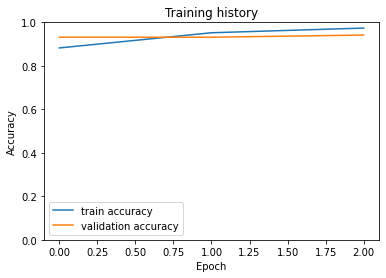

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

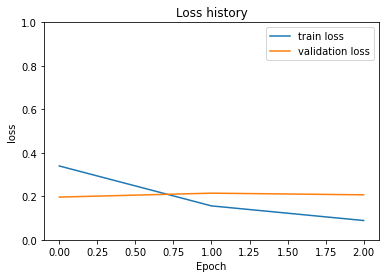

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
outputs = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device
)
#test_acc.item()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      #texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      #review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(F.softmax(outputs, dim=1))
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return predictions, prediction_probs, real_values


In [ ]:
y_pred, y_pred_probs, y_test = get_predictions(
  model,
  validasi_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_2e-05_0.3_4.bin
              precision    recall  f1-score   support

     edukasi       0.98      0.97      0.98       192
       tekno       0.93      0.96      0.95       189
      sports       1.00      0.98      0.99       444
      health       0.83      0.67      0.74        78
   lifestyle       0.90      0.94      0.92       359

   micro avg       0.95      0.95      0.95      1262
   macro avg       0.93      0.90      0.91      1262
weighted avg       0.95      0.95      0.95      1262
 samples avg       0.95      0.95      0.95      1262



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
outputs

(0.9540412044374009, 0.1905571090859137)

In [ ]:
X, y = data[:, :-1], data[:, -1]

In [ ]:
"""isi_berita = '''
Selama pandemi covid-19, rapat online seakan sudah menjadi rutinitas hampir sebagian besar para pekerja dunia. Sebab, hingga saat ini masih banyak perusahaan dan instansi yang memberlakukan work from home atau kerja dari rumah bagi karyawan mereka. Rutinitas rapat online tersebut lambat laun membuat banyak orang dilanda rasa lelah, jenuh, dan gelisah. Perasaan semacam itu umum disebut sebagai "Zoom fatigue". Meskipun dinamakan Zoom Fatigue, tapi gejala ini berlaku untuk semua rapat online melalui platform manapun, tidak hanya Zoom. Bukan hanya orang-orang biasa saja yang mengalami Zoom Fatigue. Ternyata, seorang Eric Yuan yang merupakan CEO Zoom juga merasakan hal yang sama. Hal tersebut diakui Yuan saat melakukan pertemuan virtual dengan para CEO yang diadakan oleh Wall Street Journal. Yuan mengaku, ia pernah menghadiri 19 rapat online dalam sehari. "Saya sangat lelah dengan itu," aku Yuan sambil tertawa kecil. "Saya juga mengalami meeting fatigue. Saya tidak lagi menghadiri rapat beruntun dan rasanya jauh lebih nyaman sekarang," imbuh Yuan, dirangkum KompasTekno dari The New York Post, Jumat (7/5/2021). Terlepas dari efek samping rapat online, Yuan menginginkan karyawannya untuk kembali mengadakan rapat tatap muka seperti sebelum pandemi. Yuan mengatakan karyawan Zoom akan kembali mengantor setidaknya dua hari dalam seminggu. Ciri-ciri Zoom Fatigue dan cara mengatasinya Secara umum, Zoom Fatigue bukanlah gangguan psikologi. Menurut Rosdiana Setyaningrum, MPsi, MHPEd selaku Center Director MS School & Wellbeing Center, Zoom Fatigue yang berkepanjangan akan mengganggu produktivitas dan kesehatan mental. Zoom Fatigue ditandai beberapa gejala, seperti fokus berkurang, kemampuan mengolah info melambat, motivasi menurun, cepat lelah, otot terasa pegal, mudah tersinggung, sulit membuat keputusan, koordinasi tangan dan mata menurun, serta respon melambat. Dalam artikel yang diterbitkan dalam jurnal Technology, Mind and Behavior, Jeremy Bailenson dari Virtual Human Interaction Lab Universitas Stanford, ada beberapa cara untuk mengendalikan Zoom Fatigue. Misalnya dengan memperkecil jendela aplikasi agar mata hanya terfokus pada satu wajah partisipan lain saja. Bisa juga menyembunyikan jendela wajah sendiri. Menurut penelitian, orang akan lebih kritis terhadap diri mereka ketika manatap wajah mereka secara terus menerus. Akibatnya banyak orang cenderung stress seara fisik karena berada di depan kamera dan sedang diawasi. Dengan menyembunyikan jendela wajah sendiri, pengguna bisa fokus ke partisipan lain, bukan dirinya. Selain itu, posisi yang nyaman juga bisa menjadi salah satu cara untuk mengatasi Zoom Fatigue. Hal ini dimaksudkan agar pengguna bisa bergerak dengan nyaman dan tidak duduk kaku selama rapat online. Sesekali, cobalah untuk mematikan kamera untuk melakukan peregangan jika rapat berlangsung berjam-jam. Mematikan kamera jika diperlukan disebut cukup membantu mengurangi Zoom Fatigue.
'''"""
isi_berita = '''
Timnas Indonesia sudah mendarat di Dubai, Uni Emirat Arab, Senin (17/5/2021) pukul 06.00 pagi waktu setempat, setelah delapan jam di angkasa. Rencananya, Pelatih Shin Tae-yong menggelar latihan ringan pada sore harinya.

Skuat Garuda menyiapkan diri menghadapi laga sisa penyisihan Grup G kualifikasi Piala Dunia 2022 zona Asia di Dubai, Uni Emirat Arab (UEA), 3-15 Juni 2021. Timnas Merah Putih datang lebih awal ke Dubai untuk adaptasi cuaca dan mematangkan persiapan.



Pasukan Shin Tae-yong melakoni dua laga uji coba sebelum menghadapi Thailand pada 3 Juni, lalu Vietnam 7 Juni, dan terakhir UEA pada 11 Juni di pertandingan Grup G kualifikasi Piala Dunia 2022. Uji coba direncanakan melawan timnas Afghanistan pada 25 Mei dan Oman empat hari kemudian (29 Mei).

Menurut laman resmi PSSI, di Bandara Dubai Internasional Airport, rombongan disambut Konsul Jenderal (Konjen) Republik Indonesia Dubai, Kartika Candra Negara. Setelah itu, pemain dan ofisial makan pagi dan istirahat di Hotel JA Resorts and Hotels.





Ketua Umum PSSI Mochamad Iriawan bersyukur tim tiba di Dubai dengan selamat dan perjalanan dari Jakarta lancar tanpa kendala. "Alhamdulillah mereka semua tiba dengan selamat. Saya berharap mereka bisa menjaga kesehatan, fokus, terus kerja keras demi hasil maksimal nantinya," kata Iriawan.

Sementara itu, pelatih tim Shin Tae-yong berencana langsung menggelar latihan pada sore hari waktu setempat. "Usai perjalanan dari Jakarta para pemain kami istirahat sebentar lalu nanti akan melakoni latihan ringan," ungkapnya.

Sementara gelandangtimnas Ady Setiawan mengungkapkan kegembiraaanya bergabung pertama kali dengan timnas. "Tidak menyangka bisa sampai sini, sangat bangga dan senang," ujarnyA.

"Ini pertama kali saya ke luar negeri. Saya akan menggunakan kesempatan ini sebaik-baiknya dan membayar kepercayaan pelatih dengan kerja keras."



Indonesia sudah tersingkir dari perebutan tiket putaran ketiga setelah menelan lima kekalahan. Terbenam di dasar klasemen Grup G tanpa poin. Vietnam memuncaki Grup G dengan 11 poin, lalu di bawahnya berturut-turut Malaysia (9), Thailand (8), dan UEA (6).
'''
model = model.eval()
preds_label = []
encoded_review = tokenizer.encode_plus(
  isi_berita,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  truncation=True,
  return_tensors='pt',
)

input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)

In [ ]:
prob = F.softmax(output, dim=1)

In [ ]:
prob

tensor([[1.5038e-04, 1.2029e-04, 9.9947e-01, 8.8140e-05, 1.6844e-04]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)

In [ ]:
prob[:, 1]

tensor([0.0056], device='cuda:0', grad_fn=<SelectBackward>)

In [ ]:
temp_labels=[]
for a in range(len(prob)):
    text = ""

    indeks = 0
    for b in range(len(prob[a])):
      if(prob[a][b]>0.5):
        indeks+=1
        if indeks==1:
          text += "%s"%(class_names[b])
        else:
          text += ", %s"%(class_names[b])
        #print(text)
    temp_labels.append(text)

In [ ]:
temp_labels

['sports']

In [ ]:
loss_fn = nn.BCEWithLogitsLoss().to(device)
outputs = eval_model_test_multilabel(
  model,
  test_data_loader,
  loss_fn,
  device
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
outputs

(0.22659968249499798, 0.7654516640253566)

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
cf_matrix = multilabel_confusion_matrix(y_test, y_pred_probs>0.5)

In [ ]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

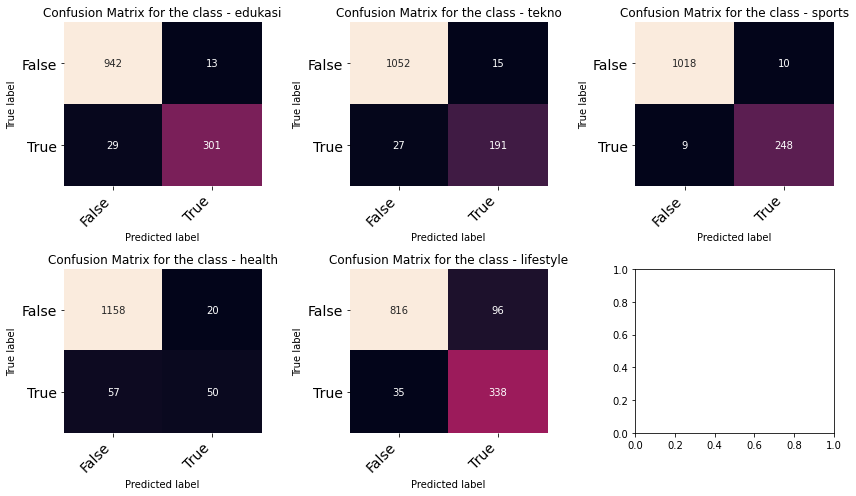

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(12, 7))
for axes, cfs_matrix, label in zip(ax.flatten(), cf_matrix, class_names):
    print_confusion_matrix(cfs_matrix, axes, label, ["False", "True"])

fig.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

In [ ]:
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_names))]))

In [ ]:
from scipy import interp
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(class_names)):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  """


In [ ]:
# Finally average it and compute AUC
mean_tpr /= len(class_names)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

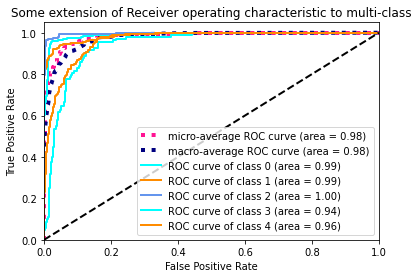

In [ ]:
from itertools import cycle
lw =2
# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(len(class_names)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))
#print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

     edukasi       1.00      0.93      0.97        91
       tekno       0.95      0.95      0.95        95
      sports       0.99      0.99      0.99       224
      health       0.79      0.92      0.85        36
   lifestyle       0.94      0.94      0.94       185

   micro avg       0.96      0.96      0.96       631
   macro avg       0.93      0.95      0.94       631
weighted avg       0.96      0.96      0.96       631
 samples avg       0.96      0.96      0.96       631



In [ ]:
idx = 192
review_text = y_review_texts[idx]
class_ids = y_test[idx]
class_pred = y_pred[idx]
predprobs = y_pred_probs[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
#250 269
isi_berita = '''hp keluaran apple adalah iphone. olahraga sangat menyenangkan dan menyehatkan'''
predstext = get_predictions_text(model, isi_berita , MAX_LEN, 0.5)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
print(predstext)

#for a in range(len(predstext)):
#  index = 0
#  print(class_names[index])
#  index+=1
  #if (float(class_names[a])>threshold):
  #  print(class_names[a])

['tekno', 'lifestyle']


In [ ]:
predstext[0]

array([0.08990626, 0.17553002, 0.99940014, 0.05432682, 0.17469932],
      dtype=float32)

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[class_ids]}')
print(class_names)
print(class_ids)
print(class_pred)
print(predprobs)

timnas u indonesia harus tel pil pahit turnamen piala asia u tahun
resmi batal konfederasi sepak bola asia afc afc resmi batal piala asia
u konfirmasi lalu surat kirim satu sepak bola seluruh indonesia pssi
jumat adapun faktor buat turnamen sebut batal wabah covid landa
seluruh dunia piala asia u kemudian ganti nama jadi piala asia u
langsung tahun uzbekistan tetap jadi tuan rumah dengan batal kompetisi
main timnas u rasa kecewa apalagi skuad garuda muda laku rangkai pusat
latih tc mentas turnamen sepak bola antarnegara asia itu namun main
minta tak tak patah semangat jalan karier bagas kaffa dkk indonesia
panjang lebih ada beberapa turnamen tingkat usia lain bisa ikut main
pasuk level timnas senior kami coba terus beri motivasi karier masih
panjang kata asisten latih timnas u nova arianto kutip bolasportcom
sabtu banyak event akan hadir mereka main timnas u lanjut mereka akan
ikut saat sampai level timnas senior jelas pria usia tahun itu belum
ajang piala dunia u langsung indonesia te

# **LOAD BERT MODEL**

In [8]:
class_names = ['edukasi', 'tekno', 'sports', 'health', 'lifestyle']
class Klasifikasi(nn.Module):

  def __init__(self, n_classes, dropout_value=0.3):
    super(Klasifikasi, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_BAHASA)
    self.drop = nn.Dropout(p=dropout_value)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(pooled_output)

In [9]:
PRE_TRAINED_MODEL_BAHASA =  'indobenchmark/indobert-base-p1'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_BAHASA)
class_names = ['edukasi', 'tekno', 'sports', 'health', 'lifestyle']
checkpoint = torch.load('/content/drive/MyDrive/Skripsi/FIX/pengujian_model_fix/indobert-base-p1_1e-05_0.2_16_2_1.bin', map_location=torch.device('cpu'))

EPOCHS = checkpoint['epoch']
DROPOUT = checkpoint['dropout']
BATCH_SIZE = checkpoint['batch_size']
MAX_LEN = checkpoint['max_len']
LEARNING_RATE = checkpoint['learning_rate']
#train_acc = checkpoint['train_acc']
#train_loss = checkpoint['train_loss']
#test_acc = checkpoint['test_acc']
#test_loss = checkpoint['test_loss']
model = Klasifikasi(len(class_names), DROPOUT)
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [10]:
model.to(device)

Klasifikasi(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)


In [11]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      #texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      #review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(F.softmax(outputs, dim=1))
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return predictions, prediction_probs, real_values
y_pred, y_pred_probs, y_test = get_predictions(
  model,
  validasi_data_baru_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCH}')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_3e-05_0.2_16_3
              precision    recall  f1-score   support

     edukasi       0.96      0.91      0.93       330
       tekno       0.93      0.88      0.90       218
      sports       0.96      0.96      0.96       257
      health       0.71      0.47      0.56       107
   lifestyle       0.78      0.91      0.84       373

   micro avg       0.88      0.88      0.88      1285
   macro avg       0.87      0.83      0.84      1285
weighted avg       0.88      0.88      0.88      1285
 samples avg       0.88      0.88      0.88      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))

softmax_layer_1e-05_0.2_2.bin
              precision    recall  f1-score   support

     edukasi       0.95      0.90      0.92       330
       tekno       0.90      0.90      0.90       218
      sports       0.97      0.96      0.97       257
      health       0.67      0.64      0.65       107
   lifestyle       0.82      0.87      0.84       373

   micro avg       0.88      0.88      0.88      1285
   macro avg       0.86      0.85      0.86      1285
weighted avg       0.88      0.88      0.88      1285
 samples avg       0.88      0.88      0.88      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


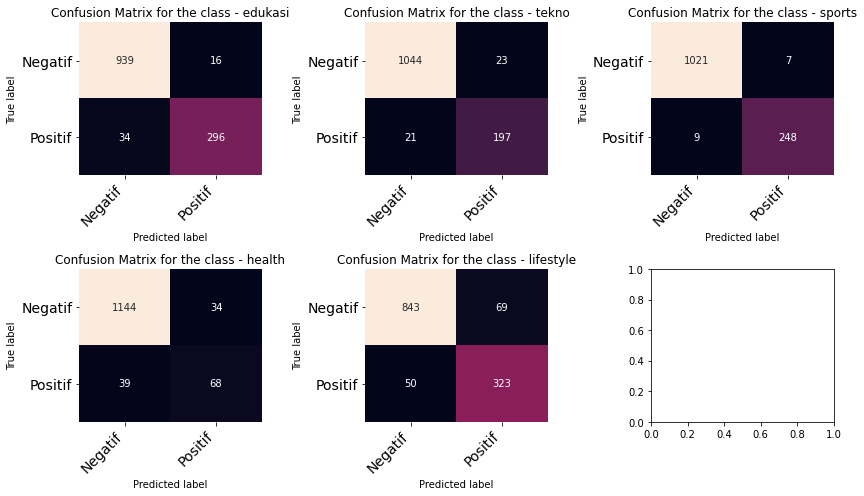

In [13]:
from sklearn.metrics import multilabel_confusion_matrix
cf_matrix = multilabel_confusion_matrix(y_test, y_pred_probs>0.5)
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)
fig, ax = plt.subplots(2, 3, figsize=(12, 7))
for axes, cfs_matrix, label in zip(ax.flatten(), cf_matrix, class_names):
    print_confusion_matrix(cfs_matrix, axes, label, ["Negatif", "Positif"])

fig.tight_layout()
plt.show()

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{BATCH_SIZE}_{EPOCHS}')
acc, loss = eval_model(
  model,
  validasi_data_baru_data_loader,
  loss_fn,
  device
)
acc, loss

In [ ]:
isi_berita = '''
Perusahaan elektronik Korea Selatan, LG Electronics (LG) menggandeng Charlie Puth untuk membuat musik di kampanye terbaru mereka.
Yang unik, kampanye itu sama dengan singkatan LG, yakni Lifes Good Campaign. Apa tujuannya? Sederhana. Untuk menggali minat, kreativitas dan bakat para generasi muda, terutama di bidang seni musik dan film di platform Instagram dan Youtube hingga 27 Juni 2021 mendatang.

Apakah masyarakat bisa ikut serta? Jawabnya bisa. Mereka dapat memilih dua program utamanya, yaitu Lifes Good Music Project dan Lifes Good Film. Di program Lifes Good Music Project ini, LG menunjuk Charlie Puth, sebagai musisi yang membuat lagu tema kampanye Lifes Good 2021.
Nantinya, partisipan diminta untuk berkreasi menciptakan karya musik baru yang dikembangkan dari lagu tema tersebut. Karya musik yang dibuat bisa berbentuk senandung, alunan dan komposisi musik yang menjadi representasi mereka terhadap kata Lifes Good.
Hasil karya yang telah selesai dibuat, lantas dapat langsung diunggah ke akun media sosial mereka seperti Instagram dan Youtube dengan menyertakan tagar #LifeisGoodMusic_LG.

Pemenang yang hasil karyanya mendapatkan nilai tertinggi berhak untuk mendapatkan 1 unit produk TV Premium LG OLED dan produk LG lainnya. Tak hanya itu, pemenang juga berkesempatan untuk tampil dan berkolaborasi dengan Charlie Puth lewat hasil karya yang dimenangkannya.
Sedangkan untuk program Lifes Good Film Project, nama Jackson Tisi terpilih sebagai sutradara yang mengarahkan Lifes Good Film. Jackson Tisi sendiri adalah seorang sutradara yang memenangkan Young Director Award 2020 lewat film dokumenter LEON.
LG mengajak para sineas untuk mengabadikan secara visual tentang peristiwa dan tempat yang memiliki makna penting bagi kehidupan mereka. Karya visual ini juga harus dapat mewakili interpretasi mereka terhadap filosofi Lifes Good.
Dalam hal ini, peserta ditantang untuk dapat menyampaikan pesan kepada penonton tentang harapan akan masa depan dan kesenangan dalam hidup mereka melalui cerita yang menginspirasi dan unik. Film ini dapat menjadi media untuk menyampaikan pesan kepada masyarakat luas mengenai makna kehidupan dari perspektif beragam," kata Jackson Tisi.

Sama dengan Lifes Good Music Project, peserta Lifes Good Film Project diharuskan mengunggah hasil karya mereka melalui sosial media Insagram dan Youtube dengan menyertakan tagar #LifeisGoodFilm_LG.
'''
model = model.eval()
preds_label = []
encoded_review = tokenizer.encode_plus(
  isi_berita,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  truncation=True,
  return_tensors='pt',
)

input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)

In [ ]:
prob = F.softmax(output, dim=1)

In [ ]:
prob

tensor([[0.0054, 0.8031, 0.0018, 0.0030, 0.1866]], grad_fn=<SoftmaxBackward>)

In [ ]:
def bubbleSort(arr):
    n = len(arr)
    string = ["top1", "top2"]
    # Traverse through all array elements
    for i in range(n-1):
    # range(n) also work but outer loop will repeat one time more than needed.
  
        # Last i elements are already in place
        for j in range(0, n-i-1):
  
            # traverse the array from 0 to n-i-1
            # Swap if the element found is greater
            # than the next element
            if arr[j] < arr[j+1] :
                arr[j], arr[j+1] = arr[j+1], arr[j]
    return string, arr

In [ ]:
resultofTop2 = defaultdict(list)
isi_berita = '''
Dengan tetap menerapkan protokol kesehatan pencegahan Covid-19, Kedutaan Besar Republik Indonesia di Moskow menggelar Pertunjukan Budaya Indonesia untuk memperingati Hari Kartini yang berlangsung di Orenzhereya Pavillion, Russia Exhibition Centre, Moskow, Sabtu (24/4/2021).
Duta Besar Indonesia untuk Rusia, Jose Tavares mengakui besarnya peran Kartini dalam emansipasi perempuan Indonesia.
Kartini telah membuka mata perempuan Indonesia bahwa pendidikan amat penting untuk meningkatkan wawasan dan mengembangkan diri, untuk berkontribusi lebih luas. Tidak hanya untuk diri sendiri tetapi juga keluarga dan negara, ujar Jose seperti dikutip dari laman Kemendikbud.

Main Gemelan hingga pertunjukan tari
Sebanyak 25 warga Rusia turut memeriahkan acara dengan memainkan instrumen Gamelan Jawa dan menampilkan beberapa tarian tradisional Indonesia diiringi vokal Gending Jawa di hadapan para tamu undangan.
Turut tampil sanggar seni budaya binaan KBRI Moskow, yaitu Sanggar Gamelan Dadali, Sanggar Tari Kirana Nusantara Dance (KND) serta para peserta Kursus Bahasa Indonesia KBRI Moskow.
Beberapa komposisi gamelan dan vokal gending Jawa yang ditampilkan pada acara ini, adalah Ladrang Nusantara, Ladrang Santi Mulya, Lancaran Gugur Gunung, Ketawang Puspawarna, Ketawang Kartini dan Ketawang Ibu Pertiwi.
Sedangkan beberapa tarian daerah Nusantara yang ditampilkan adalah Tari Tor-Tor Hata Sopisik (Sumatera Utara), Tari Merak (Jawa Barat), Tari Jathilan (Jawa Tengah), dan Tari Tifa (NTT).

Anna Mamedova, salah satu warga Rusia yang pernah mengikuti Beasiswa Seni dan Budaya Indonesia tahun 2019 menuturkan bahwa ia sudah membaca buku R.A. Kartini yang berjudul Habis Gelap, Terbitlah Terang dan sangat berkesan.
"Pemikiran Kartini sangat brilian. Akan sangat bagus apabila banyak warga Rusia yang juga dapat mengenal lebih jauh sosok Kartini, tutur Anna.
Perancang busana dan penari Rusia, Maria Yarovitskaya mengaku mengagumi acara yang digelar KBRI Moskow.
Hiburannya sangat memikat dan tampilan kostum daerah Indonesia amat indah. Terima kasih KBRI Moskow, puji Maria.
Para pemusik dan penari yang merupakan warga Rusia juga mengapresiasi gelaran pertunjukan budaya.

Tampil kembali bermain gamelan di hadapan umum setelah hampir satu tahun vakum karena pandemi COVID-19 memberikan semangat baru yang luar biasa bagi saya. Melalui gamelan saya dapat menyalurkan minat musik saya dan mendukung saya untuk bertahan di masa pandemi COVID-19 ini, ungkap Liza Moskvina, seorang pekerja media sekaligus anggota Sanggar Gamelan Dadali.
Senada dengan itu, Mahasiswi Rusia Jurusan Studi Indonesia di Moscow State University, Polina Simonik, mengungkapkan kesannya, Saya belajar Tari Tor-Tor sejak awal 2020. Namun, karena pandemi Covid-19 ini, baru kali ini saya berkesempatan tampil menari di depan teman-teman, keluarga, dan tamu undangan lainnya.
'''
model = model.eval()
preds_label = []
encoded_review = tokenizer.encode_plus(
  isi_berita,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  truncation=True,
  return_tensors='pt',
)

input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)

probs = F.softmax(output, dim=1)
print(probs)
temp = F.softmax(output, dim=1)

string, temp = bubbleSort(temp[0].detach().cpu().numpy())
probs = probs[0].detach().cpu().numpy()

top2 = []
for a in range(len(temp)):
  if(a==2):
    break
  top2.append(temp[a])

for a in range(len(probs)):
  for b in range(len(top2)):
    if(probs[a] == top2[b]):
      print(class_names[a], string[b])
      resultofTop2['kategori'].append(class_names[a])
      resultofTop2['urutan'].append(string[b])

tensor([[0.0046, 0.0128, 0.0047, 0.1638, 0.8141]], grad_fn=<SoftmaxBackward>)
health top2
lifestyle top1


In [ ]:
for a in range(len(resultofTop2['kategori'])):
  print(resultofTop2['kategori'][a], resultofTop2['urutan'][a])

health top2
lifestyle top1


In [ ]:
def get_predictions_test(model, data_loader):
  model = model.eval()
  temp = []
  real_values = []
  probs_labels = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      real_values.extend(targets)
      probs_labels.extend(F.softmax(outputs, dim=1))
  
  probs_labels = torch.stack(probs_labels).cpu()
  real_values = torch.stack(real_values).cpu()

  return probs_labels, real_values

In [ ]:
y_pred_probs, y_test = get_predictions_test(
  model,
  test_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def SubmissionTest(df, y_pred_prob):
  temp_labels=[]
  for a in range(len(y_pred_prob)):
    text = ""

    indeks = 0
    for b in range(len(y_pred_prob[a])):
      if(y_pred_prob[a][b]>0.5):
        indeks+=1
        if indeks==1:
          text += "%s"%(class_names[b])
        else:
          text += ", %s"%(class_names[b])
        #print(text)
    temp_labels.append(text)

  test_df['y_true_prediction'] = temp_labels
  
  #test_df.drop(columns='kategori_int')
  test_df.to_csv('submission.csv', index=False, encoding='utf-8')

    

In [ ]:
SubmissionTest(test_df, y_pred_probs)

In [ ]:
y_pred_probs[2]

tensor([1.9523e-03, 3.5021e-03, 3.9771e-04, 2.4503e-03, 9.9170e-01])